Spatial Working Memory Implementation of (Compte et. al.)
===============================================

Excersise from the book *Neuronal Dynamics
From single neurons to networks and models of cognition*, Chapter 18, 
by Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski

Detailed excersise page: https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/spatial-working-memory.html

The model has been introduced by Compte et. al. [1]. The parameters used here differ from the original paper. They are changed such that we can still study some effects while simulating a small network.

[1] Compte, A., Brunel, N., Goldman-Rakic, P. S., & Wang, X. J. (2000). Synaptic mechanisms and network dynamics underlying spatial working memory in a cortical network model. Cerebral Cortex, 10(9), 910-923.

In [1]:
# Load libraries

# Compatibility between Python 2 and Python 3
from __future__ import division, print_function, unicode_literals, absolute_import

%matplotlib inline
import math
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from neurodynex.working_memory_network import wm_model
from neurodynex.working_memory_network import wm_model_modified
from neurodynex.tools import plot_tools

from utility_functions import *

import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

collected_data_file = 'Data/collected_drift_trials.npy' # The file to store the collected trials data

Example Run of the Spatial Working Memory Ring Attractor and Plotting
----------------------------------------------------------------------

INFO       width adjusted from 1. ms to 1.1 ms [brian2.monitors.ratemonitor.adjusted_width]


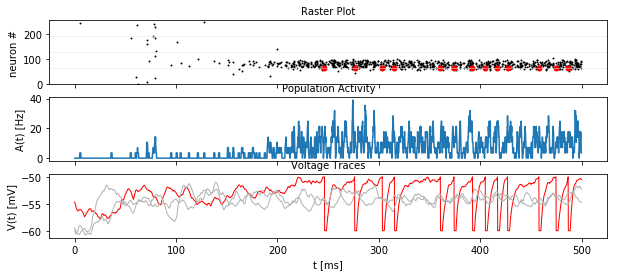

In [2]:
# Run the default model in the package
# N_excitatory=256, N_inhibitory=64, weight_scaling_factor=8.0
wm_model.getting_started()

**Figure caption:**

_Top:_ A weak stimulus, centered at 120deg, is applied to a subset of the excitatory population from t=100ms to t=300ms. This creates an activity bump in the excitatory subpopulation. The activity is sustained after the end of the stimulation. 

_Middle:_ The population activity increases over time while the stimulus is applied. 

_Bottom:_ Voltage traces for three selected neurons. The spikes of the red neuron are visible in the top and bottom panel.

Run the simulation for custom ring attractor parameters
------------------------------------------------------------------

N_excitatory=1024, N_inhibitory=256, N_extern_poisson=1000, weight_scaling_factor=2.0, stimulus_center_deg=180, stimulus_width_deg=40, stimulus_strength=70. * pamp, t_stimulus_start=0. * second, t_stimulus_duration=0. * second

INFO       width adjusted from 1. ms to 1.05 ms [brian2.monitors.ratemonitor.adjusted_width]


(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1296152d0>)

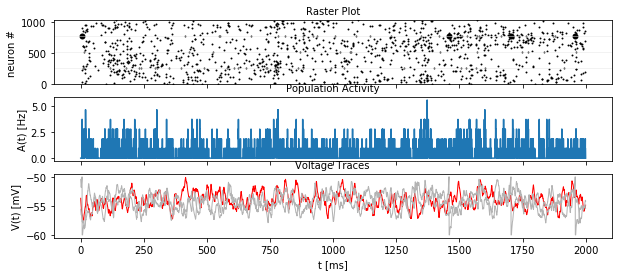

In [2]:
# Run with unstructured Poisson input (all neurons receive similar activity)
sim_time_duration    = 2000. * ms
poisson_firing_rate  = 1.3 * Hz
sigma_weight_profile = 20.
Jpos_excit2excit     = 1.6
t_stimulus_start=0*ms
t_stimulus_duration=0*ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c8ea290>)

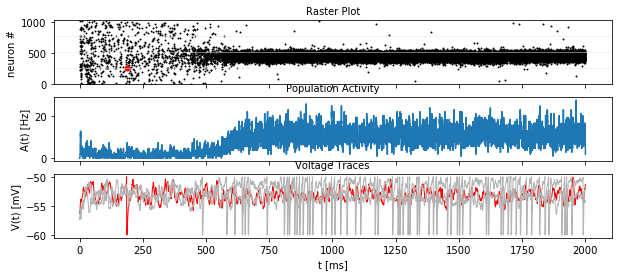

In [3]:
# Run with unstructured Poisson input of higher impulse rate (all neurons receive similar activity)
sim_time_duration    = 2000. * ms
poisson_firing_rate  = 2.3 * Hz
sigma_weight_profile = 20.
Jpos_excit2excit     = 1.6
t_stimulus_start=0*ms
t_stimulus_duration=0*ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

**12.1.2. Question: Unstructured input: Change the firing rate of the external population to 2.2Hz. Run the simulation a few times. What do you observe?**
I observe that by increasing the stimulus firing rate from 1.3Hz to 2.3Hz, even though all neurons receive similar spiking activity, an activity 'bump' starts forming eventually around 750ms from the start fo the simulation. The activity 'bump' is formed at a random theta direction. The strange thing is according to the documendation the stimulus has duration of 0s. The plot however indicates higher spiking rate in all neurons which seems to be adequate condition for a spontaneous activity 'bump' to be formed just by chance. Another observation is that by increasing the external input firing rate to 1.4Hz is *occasionally* sufficient to cause an activity 'bump' but it takes more time to do so (around 2s-3s of simulation). That is 1.4Hz -> 3s, 1.8Hz -> 0.5s-1.25s, 2.0Hz -> 0.75s, 2.3Hz -> 0.75s. It seems that the more noise in the input signal the more likely that a spontaneous activity 'bump' will be formed.

**Strange behaviour:** The poisson\_firing\_rate seems to be applied during the whole duration of the simulation when both t\_stimulus\_start and t\_stimulus\_duration are set to 0ms. In this case the activity 'bump' is formed at a time depending on the poisson\_firing\_rate value. However if we limit the t\_stimulus\_duration to say 100ms then an activity 'bump' is formed immediatelly regardless of the poisson_firing_rate value being 1.3Hz or 2.3Hz. 

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13bc2ae50>)

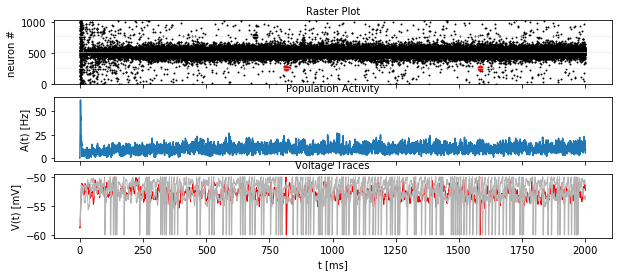

In [22]:
# Run with unstructured Poisson input of higher impulse rate (all neurons receive similar activity)
sim_time_duration    = 2000. * ms
poisson_firing_rate  = 5 * Hz
sigma_weight_profile = 20.
Jpos_excit2excit     = 1.6
t_stimulus_start=0*ms
t_stimulus_duration=200*ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Investigate synaptic strength profile
------------------------------------------

### Plotting of the synaptic strengths profile of neuron tuned at 45deg

Let's plot the synaptic strengths of all input synapses of a neuron tuned to 45deg. The synaptic strength from each presynaptic neuron to a postsynaptic neuron tuned to the preferred direction of 45deg are displayed. 

Text(0,0.5,u'Synaptic strength')

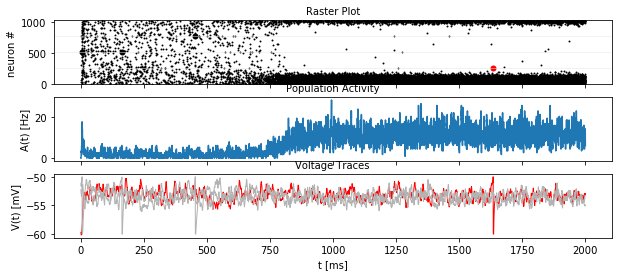

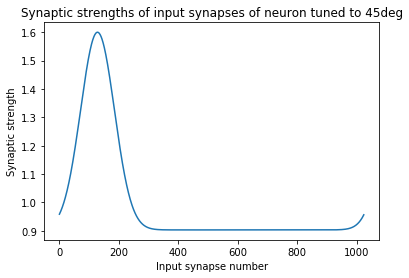

In [6]:
sim_time_duration    = 2000. * ms
poisson_firing_rate  = 2.3 * Hz
sigma_weight_profile = 20.
Jpos_excit2excit     = 1.6
t_stimulus_start=0*ms
t_stimulus_duration=0*ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

plt.figure()
plt.plot(weight_profile_45)
plt.title('Synaptic strengths of input synapses of neuron tuned to 45deg')
plt.xlabel('Input synapse number')
plt.ylabel('Synaptic strength')

**Figure caption:**

Synaptic profile of one postsynaptic neuron tuned to preferred direction 45deg. Vertical axis (ordinate) is the synaptic strength of each presynaptic neuron connecting to this postsynaptic neuron. Horizontal axis (abscissa) is the presynaptic neuron ID. 

**12.1.3. Question: Weight profile: What is the effect of Jpos\_excit2excit and sigma\_weight\_profile?** 

Changing Jpos\_excit2excit determines the amplitude (max value) of the synaptic strength distribution. With higher value of Jpos\_excit2excit a spontaneous activity 'bump' is more likely to be formed and earlier. 

Changing sigma\_weight\_profile affects the Standard Deviation (with) of the gaussian excitatory synaptic strength distribution. The higher the value of sigma\_weight\_profile the wider the synaptic strength distribution width and the wider the activity 'bump'. With higher value of sigma\_weight\_profile a spontaneous activity 'bump' is more likely to be formed and earlier.

Response to Structured Input Stimulus
---------------------------------------------

We now apply stimulation to a subset of the excitatory population of neurons.

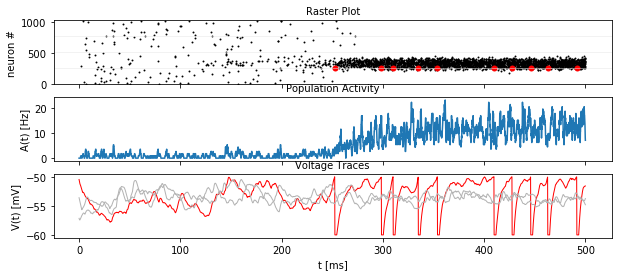

In [7]:
stimulus_center_deg=120
stimulus_width_deg=30
stimulus_strength=.06 * namp
t_stimulus_start=100. * ms
t_stimulus_duration=200. * ms
sim_time_duration=500. * ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)
plt.show()

**12.2.1. Question: Integration of input:**

**At which time can you identify a change in the population activity?** 
You can see a change in the spiking activity of the stimulated subset of the neurons shortly after the current injection is applied (t=100ms) but the activity 'bump' is only getting strong and sustained at t=200ms that is 100ms after the commencment of the current injection. 

**Increase the stimulus strength to 0.5namp. What happens when the stimulus stops?** 
Now the activity 'bump' starts almost as soon as the current injection starts at t=100ms. With that level of stimulus there is a drop is the population average activity when the stimulus stops. 

**Increase the stimulus width to 60deg (stimulus_strength=0.1 * b2.namp, stimulus center = 120deg). How does the bump shape change?**
The activity 'bump' however is wider during the stimulation and then returns to normal activity 'bump' width.

**12.2.2. Question: Role of the inhibitory population:** 

**Remove the inhibitory population by setting its size to the minimal size N_inhibitory = 1. Describe your observations.**
Without the inhibitory population all excitatory neurons fire and there is a periodic oscilation of activity. 

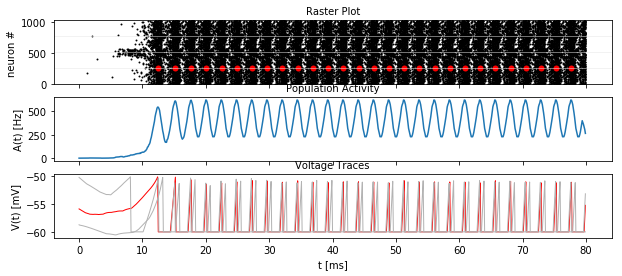

In [8]:
N_inhibitory = 1
stimulus_strength=0.65 * namp
t_stimulus_start=5 * ms
t_stimulus_duration=25 * ms
sim_time_duration=80. * ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(N_inhibitory = N_inhibitory, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)
plt.show()

**12.2.2. Question: Role of the inhibitory population:** 
**Plot the raster plot of population activity and voltage traces for the inhibitory population.**

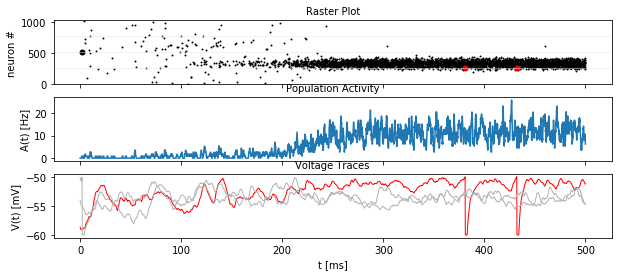

Text(0,0.5,u'Inhibitory Neuron ID')

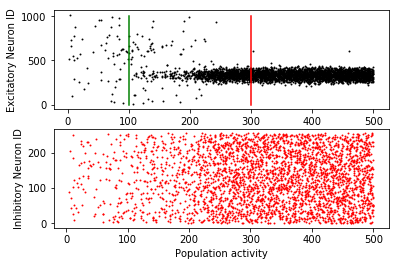

In [9]:
stimulus_center_deg=120
stimulus_width_deg=30
stimulus_strength=.06 * namp
t_stimulus_start=100 * ms
t_stimulus_duration=200 * ms
sim_time_duration=500. * ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)
plt.show()


plt.figure()
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax1.scatter(spike_monitor_excit.t/ms, spike_monitor_excit.i,
                              marker=".", c="k", s=15, lw=0)
ax2.scatter(spike_monitor_inhib.t/ms, spike_monitor_inhib.i,
                              marker=".", c="r", s=15, lw=0)
ax1.plot([100,100], [0,1000], 'g')
ax1.plot([300,300], [0,1000], 'r')
plt.xlabel('Population activity')
ax1.set_ylabel('Excitatory Neuron ID')
ax2.set_ylabel('Inhibitory Neuron ID')

**Figure caption:**

Top: The raster plot of the excitatory neuronal population with greed and red verticla lines indicating the commencement and end of the stimulus.

Bottom: The raster plot of the inhibitory neuronal population activity.

12.3. Exercise: Decoding the population activity into a population vector
------------------------------------------------------------------------------------



In [4]:
#t = 400*ms
#t_delta = 10*ms
#tmin = t - t_delta
#tmax = t + t_delta
#get_spike_count(spike_monitor_excit, np.arange(0,1024).tolist(), tmin, tmax)

Text(0,0.5,u'Spike rate [Hz]')

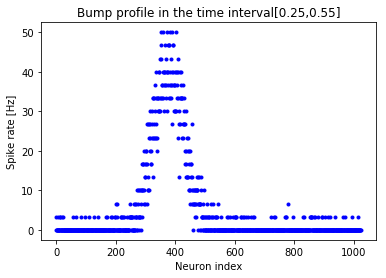

In [5]:
t = 400*ms  # time point of interest
t_window = 300*ms # width of the window over which the average is taken

t_min = t-t_window/2
t_max = t+t_window/2
spike_counts = get_spike_count(spike_monitor_excit, idx_monitored_neurons_excit, t_min, t_max)
spike_rates = spike_counts/(t_max-t_min)/second
plt.plot(spike_rates, ".b")
plt.title("Bump profile in the time interval[{},{}]".format(t_min, t_max))
plt.xlabel("Neuron index")
plt.ylabel("Spike rate [Hz]")

(853.4033104740965, -1077.528742359507)

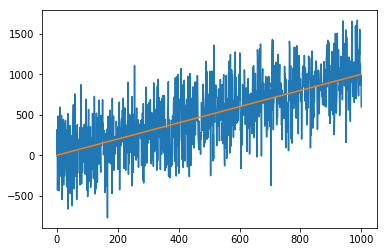

In [8]:
signal = np.linspace(0, 1000, 1001)
noise_portion = 0.1
noisy_signal = add_gaussian_white_noise_by_magnitude(signal, noise_portion)

plt.plot(noisy_signal)
plt.plot(signal)

np.max(noisy_signal - signal), np.min(noisy_signal - signal)

**12.3.3. Computing the population vector**

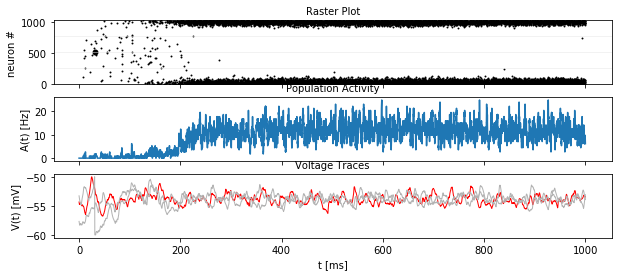

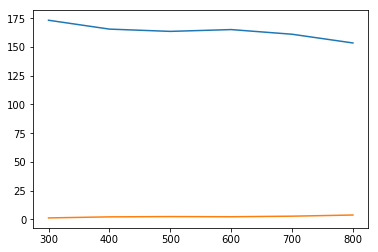

In [9]:
# Example how to create an array of timestamps spaced by snapshot_interval in the interval of interest.
stimulus_center_deg = 360
stimulus_width_deg  = 30
stimulus_strength   = .06 * namp
t_stimulus_start    = 100 * ms
t_stimulus_duration = 200 * ms
sim_time_duration   = 1000. * ms
t_window_width      = 200*ms
snapshot_interval   = 100*ms
N_excitatory = 1024

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)
plt.show()

t_snapshots = range(
    int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
    int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
    int(round(snapshot_interval/ms))  # spacing between time stamps
    )*ms

# how your function get_theta_time_series could be called:
theta_ts = get_theta_time_series(spike_monitor_excit, idx_monitored_neurons_excit, N_excitatory, t_snapshots, t_window_width)
theta_ts_v_a = get_theta_time_series_vec_add(spike_monitor_excit, idx_monitored_neurons_excit, N_excitatory, t_snapshots, t_window_width)
theta_ts_v_a = theta_ts_v_a[1]

# plot theta vs time using pyplot
plt.figure()
plt.plot(t_snapshots/ms, theta_ts)
plt.plot(t_snapshots/ms, theta_ts_v_a)

**12.3.4. Exercise: Visualize the diffusion of the population vector**

Simulate a network of size N_excitatory = 2048. Apply a stimulus from t=100ms to t=300ms. Plot theta(t). Note that when you increase the size of the excitatory population you also have to increase the inhibitory population and the weights (``N_inhibitory'' and ``weight_scaling_factor''). When doubling the number of presynaptic neurons, you have to scale the weights by 0.5 to keep the total synaptic input the same.

In [2]:
def run_trials(num_of_trials         = 20, 
               collected_data_file   = 'Data/collected_drift_trials.npy', 
               stimulus_center_deg   = 180,
               stimulus_width_deg    = 60,
               stimulus_strength     = .06 * namp,
               t_stimulus_start      = 100 * ms,
               t_stimulus_duration   = 200 * ms,
               N_excitatory          = 1024,
               N_inhibitory          = 256,
               weight_scaling_factor = 2.0,
               sim_time_duration     = 10000. * ms,
               t_window_width      = 200*ms,
               snapshot_interval   = 100*ms,
               synaptic_noise_amount = 0.0
              ):
    """
        Runs trials of the activity bump drift and collects corresponding time series
        
        num_of_trials (default 20) : How many trials of the experiment to run. 
        collected_data_file (default 'Data/collected_drift_trials.npy') : File to store collected data in.
        stimulus_center_deg (default 180) : Stimulus heading. 
        
    """
    
    #num_of_trials = 20
    #collected_data_file = 'Data/collected_drift_trials.npy' # The file to store the collected trials data

    # Try to load existing data if any otherwise create an empty collection
    try:
        collected_trials_data = np.load(collected_data_file, allow_pickle=True, encoding='bytes')
    except: 
        collected_trials_data = np.array([]) # Collected trials data records list

    # stimulus_center_deg   = 180
    # stimulus_width_deg    = 60
    # stimulus_strength     = .06 * namp
    # t_stimulus_start      = 100 * ms
    # t_stimulus_duration   = 200 * ms
    #sim_time_duration     = 10000. * ms

    #N_excitatory          = 1024 # 2048
    #N_inhibitory          = 256  # 512
    #weight_scaling_factor = 2.0 # 4.0

    #t_window_width      = 200*ms
    #snapshot_interval   = 100*ms


    for iteration in range(num_of_trials):
        print('Trial: ', iteration+1)
        rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model_modified.simulate_wm(N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration, synaptic_noise_amount = synaptic_noise_amount)
        
        t_snapshots = range(
            int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
            int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
            int(round(snapshot_interval/ms))  # spacing between time stamps
            )*ms
        
        # Calculate the population vector angle theta
        theta_ts = get_theta_time_series_vec_add(spike_monitor_excit, idx_monitored_neurons_excit, N_excitatory, t_snapshots, t_window_width)

        # Create a new dictionary with the collected data
        collected_data = dict()
        # Simulation set up info
        collected_data['stimulus_center_deg'] = stimulus_center_deg
        collected_data['stimulus_width_deg'] = stimulus_width_deg
        collected_data['t_stimulus_start'] = t_stimulus_start
        collected_data['t_stimulus_duration'] = t_stimulus_duration
        collected_data['sim_time_duration'] = sim_time_duration
        collected_data['N_excitatory'] = N_excitatory
        collected_data['N_inhibitory'] = N_inhibitory
        collected_data['weight_scaling_factor'] = weight_scaling_factor
        collected_data['synaptic_noise_amount'] = synaptic_noise_amount

        # Data
        #collected_data['rate_monitor_excit'] = rate_monitor_excit
        collected_data['spike_monitor_excit'] = spike_monitor_excit.spike_trains()
        #collected_data['voltage_monitor_excit'] = voltage_monitor_excit
        collected_data['idx_monitored_neurons_excit'] = idx_monitored_neurons_excit
        #collected_data['rate_monitor_inhib'] = rate_monitor_inhib
        collected_data['spike_monitor_inhib'] = spike_monitor_inhib.spike_trains()
        #collected_data['voltage_monitor_inhib'] = voltage_monitor_inhib
        collected_data['idx_monitored_neurons_inhib'] = idx_monitored_neurons_inhib
        collected_data['theta_ts'] = theta_ts
        # Add new data record to the collected trials data
        collected_trials_data = np.append(collected_trials_data, collected_data)

    # Save all data in the file
    np.save(collected_data_file, collected_trials_data, allow_pickle=True)
    
    fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)
    plt.show()


In [3]:
# Run the trials (Note this will take a long time)

# Network hyper-parameter
# [(N_excitatory, N_inhibitory, weight_scaling_factor), ...]
network_parameters = [
    (1024, 256, 2.0),
    (2048, 512, 1.0),
    (512,  128, 4.0)
]

synaptic_noise_amount_list = [0.01, 0.05, 0.1, 0.5]


# Collect data for three network sizes and 9 stimulus headings
def explore_heading_angles():
    for i, network_param in enumerate(network_parameters):
        for stim_degrees in range(0, 360+1, 45):
            print('Experiment: {:3}  stim_degrees = {:3}'.format(i+1, stim_degrees))
            run_trials(num_of_trials         = 10, 
                       collected_data_file   = collected_data_file, 
                       stimulus_center_deg   = stim_degrees,
                       N_excitatory          = network_param[0],
                       N_inhibitory          = network_param[1],
                       weight_scaling_factor = network_param[2],
                       sim_time_duration     = 10000. * ms,
                       synaptic_noise_amount = 0.0
                      )

# Collect data for three network sizes and different noise levels
def explore_noise_levels():
    for i, network_param in enumerate(network_parameters):
        for synaptic_noise_amount in synaptic_noise_amount_list:
            print('Experiment: {:3}  synaptic_noise_amount = {:3}'.format(i+1, synaptic_noise_amount))
            run_trials(num_of_trials         = 10, 
                       collected_data_file   = collected_data_file, 
                       stimulus_center_deg   = 180,
                       N_excitatory          = network_param[0],
                       N_inhibitory          = network_param[1],
                       weight_scaling_factor = network_param[2],
                       sim_time_duration     = 10000. * ms,
                       synaptic_noise_amount = synaptic_noise_amount
                      )


explore_heading_angles()
explore_noise_levels()

Experiment:   1  stim_degrees =   0


WARNING    /Users/john/Library/Python/2.7/lib/python/site-packages/brian2/units/fundamentalunits.py:207: RuntimeWarning: divide by zero encountered in log10
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


Trial:  1


KeyboardInterrupt: 

Plot and Explore the collected trial results
-------------------------------------------------

In [24]:
def scale_circ_to_line(theta_ts_list, scale=[(0, 360), (0, 100)]):
    if isinstance(theta_ts_list, list):
        theta_ts_list = np.array(theta_ts_list)
    normalised_theta_ts_list = theta_ts_list / scale[0][1] # [0, 1]
    distance_represented = normalised_theta_ts_list * scale[1][1]
    return distance_represented

def dispertion_of_absolute_deviation(expected_value, time_series_list):
    """
        Returns a measure of dispertion of the absolute deviation (MAD) of time series produced 
        by multiple trials at each point in time. That is a measure of 
        dispersion over time. 
        $MAD = \frac{1}{N} \sum_{i=0}^{N} \abs{x_{i} - mean(X)}$ 
        MAD is a better measure than standard deviation (SD). 
        
        expected_value   : The expected value for MAD normally is the mean of 
                           the sample. That is the mean value of all time series 
                           at that point in time. However you can provide 
                           any expected value here.
        time_series_list : A list or np.array containing np.arrays of several 
                           time series. All time series must have the same 
                           number of items. 
        Returns          : A time series with elements the dispertion of the absolute 
                           deviations at each point in time. It has the same number 
                           of items as the contained time series. 
    """
    
    # The absolute value of the differences of the time series samples from the expected value
    
    abs_diff_list = []
    # Get the absolute deviation of each item of the series from the expected value
    for ts in time_series_list:
        abs_diff = np.abs(np.ones(len(ts)) * expected_value - ts)
        abs_diff_list.append(abs_diff)
    
    # Get the mean absolute deviation across all time series at each point in time
    abs_diff_mean = np.std(abs_diff_list, axis=0)
    
    return abs_diff_mean






def plot_time_series_list(collected_data_file, 
                          stimulus_center_deg   = None,
                          stimulus_width_deg    = None,
                          sim_time_duration     = None,
                          N_excitatory          = None,
                          synaptic_noise_amount = None,
                          tau_excit             = None, 
                          tau_inhib             = None, 
                          unwrap_modulo_angles  = False
                          ):
    # Example how to create an array of timestamps spaced by snapshot_interval in the interval of interest.
    t_window_width      = 200*ms # was 100*ms
    snapshot_interval   = 100*ms

    time_series_collection = dict()
    
    # Try to load existing data if any otherwise create an empty collection
    try:
        #collected_trials_data = np.load(collected_data_file, allow_pickle=True, encoding='bytes')
        # Load only records with specific values
        collected_trials_data = pick_data_samples(collected_data_file, 
                                stimulus_center_deg   = stimulus_center_deg,
                                stimulus_width_deg    = stimulus_width_deg,
                                sim_time_duration     = sim_time_duration,
                                N_excitatory          = N_excitatory,
                                synaptic_noise_amount = synaptic_noise_amount, 
                                tau_excit             = tau_excit, 
                                tau_inhib             = tau_inhib, 
                                operator              = 'and'
                             )
    except: 
        collected_trials_data = np.array([]) # Collected trials data records list

    theta_ts_list = [] # To store the time series
    
    # We use enumerate to add a count to the iterated items of the iterator
    for i, item in enumerate(collected_trials_data):
        # Simulation set up info
        stimulus_center_deg              = item['stimulus_center_deg']
        stimulus_width_deg               = item['stimulus_width_deg']
        t_stimulus_start                 = item['t_stimulus_start']
        t_stimulus_duration              = item['t_stimulus_duration']
        sim_time_duration                = item['sim_time_duration']
        N_excitatory                     = item['N_excitatory']
        N_inhibitory                     = item['N_inhibitory']
        weight_scaling_factor            = item['weight_scaling_factor']

        # Data
        spike_monitor_excit_spike_trains = item['spike_monitor_excit']
        idx_monitored_neurons_excit      = item['idx_monitored_neurons_excit']
        spike_monitor_inhib_spike_trains = item['spike_monitor_inhib']
        idx_monitored_neurons_inhib      = item['idx_monitored_neurons_inhib']
        t_window_width                   = item['t_window_width']
        snapshot_interval                = item['snapshot_interval']
        theta_ts                         = item['theta_ts']
        t_snapshots                      = item['t_snapshots']

        # The newest version of get_theta_time_series_vec_add(...) returns a tuple (r_time_series, theta_time_series) 
        # Earlier versions were returning only theta_time_series
        if isinstance(theta_ts, tuple):
            theta_ts = theta_ts[1]

        #t_snapshots = range(
        #    int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
        #    int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
        #    int(round(snapshot_interval/ms))  # spacing between time stamps
        #    )*ms

        #theta_ts = get_theta_time_series_vec_add(spike_monitor_excit_spike_trains, idx_monitored_neurons_excit, N_excitatory, t_snapshots, t_window_width)
        
        # Do not limit angles to 0-360 degrees. Convert to increasing or decreasing non wrapping numbers.
        if unwrap_modulo_angles:
            theta_ts = unwrap_modulo_time_series(theta_ts, modulo = 360)
        
        # Store the time series
        theta_ts_list.append(theta_ts)
    
    if len(theta_ts_list) > 0:
        # Calculate the Mean Absolute Deviations (MAD)
        theta_ts_abs_diff_mean = mean_absolute_deviation(expected_value=stimulus_center_deg, time_series_list=theta_ts_list)
        theta_ts_abs_diff_std = dispertion_of_absolute_deviation(expected_value=stimulus_center_deg, time_series_list=theta_ts_list)

        time_series_collection['theta_ts_list']          = theta_ts_list
        time_series_collection['theta_ts_abs_diff_mean'] = theta_ts_abs_diff_mean
        time_series_collection['theta_ts_abs_diff_std']  = theta_ts_abs_diff_std
        time_series_collection['t_snapshots']            = t_snapshots
        time_series_collection['stimulus_center_deg']    = stimulus_center_deg
        time_series_collection['N_excitatory']           = N_excitatory


        return time_series_collection
    else:
        return None


def pick_angle_data(collected_data_file, stimulus_center_deg_list, N_excitatory = 1024, synaptic_noise_amount = 0, unwrap_modulo_angles = False):
    # Plot collected time series for different stimulus angle locations
    plot_keys_list = stimulus_center_deg_list
    plot_items_dict = dict()
    num_of_plot_keys = len(plot_keys_list)
    viridis = plt.cm.get_cmap('viridis')

    for i,plot_key in enumerate(plot_keys_list):
        plot_item = plot_time_series_list(collected_data_file, 
                                          stimulus_center_deg   = plot_key,
                                          stimulus_width_deg    = None,
                                          sim_time_duration     = None,
                                          N_excitatory          = N_excitatory,
                                          synaptic_noise_amount = synaptic_noise_amount,
                                          unwrap_modulo_angles  = unwrap_modulo_angles
                                         )
        if plot_item is not None:
            plot_item['color']               = viridis(i/num_of_plot_keys)

        plot_items_dict[plot_key] = plot_item
    return plot_items_dict


def pick_noise_data(collected_data_file, synaptic_noise_amount_list, N_excitatory = 2048, stimulus_center_deg = 180, unwrap_modulo_angles = False):
    # Plot collected time series for different stimulus angle locations
    plot_keys_list = synaptic_noise_amount_list
    plot_items_dict = dict()
    num_of_plot_keys = len(plot_keys_list)
    viridis = plt.cm.get_cmap('viridis')

    for i,plot_key in enumerate(plot_keys_list):
        plot_item = plot_time_series_list(collected_data_file, 
                                          stimulus_center_deg   = stimulus_center_deg,
                                          stimulus_width_deg    = None,
                                          sim_time_duration     = None,
                                          N_excitatory          = N_excitatory,
                                          synaptic_noise_amount = plot_key,
                                          unwrap_modulo_angles  = unwrap_modulo_angles
                                         )
        if plot_item is not None:
            plot_item['color']               = viridis(i/num_of_plot_keys)

        plot_items_dict[plot_key] = plot_item
    return plot_items_dict


def pick_net_size_data(collected_data_file, N_excitatory_list, stimulus_center_deg = 180, synaptic_noise_amount = 0, unwrap_modulo_angles = False):
    # Plot collected time series for different stimulus angle locations
    plot_keys_list = N_excitatory_list
    plot_items_dict = dict()
    num_of_plot_keys = len(plot_keys_list)
    viridis = plt.cm.get_cmap('viridis')

    for i,plot_key in enumerate(plot_keys_list):
        plot_item = plot_time_series_list(collected_data_file, 
                                          stimulus_center_deg   = stimulus_center_deg,
                                          stimulus_width_deg    = None,
                                          sim_time_duration     = None,
                                          N_excitatory          = plot_key,
                                          synaptic_noise_amount = synaptic_noise_amount,
                                          unwrap_modulo_angles  = unwrap_modulo_angles
                                         )
        if plot_item is not None:
            plot_item['color']               = viridis(i/num_of_plot_keys)

        plot_items_dict[plot_key] = plot_item
    return plot_items_dict


def pick_tau_data(collected_data_file, N_excitatory, stimulus_center_deg = 180, synaptic_noise_amount = 0, tau_excit_list = None, tau_inhib_list = None, unwrap_modulo_angles = False):
    # Plot collected time series for different stimulus angle locations
    plot_keys_list = tau_excit_list
    plot_items_dict = dict()
    num_of_plot_keys = len(plot_keys_list)
    viridis = plt.cm.get_cmap('viridis')

    for i,plot_key in enumerate(plot_keys_list):
        plot_item = plot_time_series_list(collected_data_file, 
                                          stimulus_center_deg   = stimulus_center_deg,
                                          stimulus_width_deg    = None,
                                          sim_time_duration     = None,
                                          N_excitatory          = N_excitatory,
                                          synaptic_noise_amount = synaptic_noise_amount,
                                          tau_excit             = plot_key, 
                                          tau_inhib             = None, 
                                          unwrap_modulo_angles  = unwrap_modulo_angles
                                         )
        if plot_item is not None:
            plot_item['color']               = viridis(i/num_of_plot_keys)

        plot_items_dict[plot_key / ms] = plot_item
    return plot_items_dict



def calc_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, start_time=0, end_time=1):
    if isinstance(start_time, Quantity):
        start_time = start_time / second
    if isinstance(end_time, Quantity):
        end_time = end_time / second
    
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']

            if isinstance(t_snapshots, Quantity):
                t_snapshots = t_snapshots / second

            index_start_time = np.argmax(t_snapshots >= start_time)
            index_end_time = np.argmin(t_snapshots <= end_time)
            
            theta_ts_abs_diff_mean_segment = theta_ts_abs_diff_mean[index_start_time:index_end_time]
            delta_theta_ts_abs_diff_mean_segment = np.max(theta_ts_abs_diff_mean_segment) - np.min(theta_ts_abs_diff_mean_segment)
            delta_time = end_time - start_time
            
            theta_mean_absolute_deviation_rate = delta_theta_ts_abs_diff_mean_segment / delta_time
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = theta_mean_absolute_deviation_rate
    
    return plot_items_dict

def print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(°/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, theta_mean_absolute_deviation_rate))


def print_theta_mean_absolute_deviation_rate_scaled(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units, scale=[(0, 360), (0, 100)]):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(units/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            distance_represented_mean_absolute_deviation_rate = scale_circ_to_line(theta_mean_absolute_deviation_rate, scale)
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, distance_represented_mean_absolute_deviation_rate))


def plot_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units):
    pass


def plot_data(plot_items_dict, plot_keys_list, plot_key_units, xlim=None, ylim1=[0, 360], ylim2=None, title=None, show_legend=True):
    # Plot all the individual time series recordings
    figure_handles = [] # Stores handles to the produced figures

    fig = plt.figure()
    figure_handles.append(fig)
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            color = plot_item['color']
            theta_ts_list = plot_item['theta_ts_list']
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']
            # print(plot_key, plot_item['plot_key'])
            for i,theta_ts_item in enumerate(theta_ts_list):
                # print(plot_key, plot_item['plot_key'], t_snapshots.shape, len(theta_ts_item))
                # plot theta vs time using pyplot
                if i == 0:
                    plt.plot(t_snapshots/second, theta_ts_item, color=mcolors.to_rgba(color, alpha=0.2), label=str(plot_key)+plot_key_units)
                else:
                    plt.plot(t_snapshots/second, theta_ts_item, color=mcolors.to_rgba(color, alpha=0.2))
            plt.xlabel('Time (s)')
            plt.ylabel('Heading ($^{o}$)')
            if title: plt.title(title)
            if ylim1: plt.ylim(ylim1)
            if xlim: plt.xlim(xlim)
            # if fewer than 20 legends show them
            if show_legend and len(plot_keys_list) < 20:
                plt.legend()
            #plt.show()

    # Plot the Mean Absolute Deviation of the time series across time
    fig = plt.figure()
    figure_handles.append(fig)
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            color = plot_item['color']
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']

            plt.plot(t_snapshots/second, theta_ts_abs_diff_mean, color=mcolors.to_rgba(color, alpha=1), label=str(plot_key)+plot_key_units)
            #plt.ylim([0,360]) # Show the whole range of angles
            plt.xlabel('Time (s)')
            plt.ylabel('Mean Absolute Deviation ($^{o}$)')
            if title: plt.title(title)
            if ylim2: plt.ylim(ylim2)
            if xlim: plt.xlim(xlim)
            # if fewer than 20 legends show them
            if show_legend and len(plot_keys_list) < 20:
                plt.legend()

    # Plot the Standard Deviation of Absolute Deviation of the time series across time
    fig = plt.figure()
    figure_handles.append(fig)
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            color = plot_item['color']
            theta_ts_abs_diff_std = plot_item['theta_ts_abs_diff_std']
            t_snapshots = plot_item['t_snapshots']

            plt.plot(t_snapshots/second, theta_ts_abs_diff_std, color=mcolors.to_rgba(color, alpha=1), label=str(plot_key)+plot_key_units)
            #plt.ylim([0,360]) # Show the whole range of angles
            plt.xlabel('Time (s)')
            plt.ylabel('SD of Absolute Deviation ($^{o}$)')
            if title: plt.title(title)
            if ylim2: plt.ylim(ylim2)
            if xlim: plt.xlim(xlim)
            # if fewer than 20 legends show them
            if show_legend and len(plot_keys_list) < 20:
                plt.legend()
    
    # Plot the Error Bars of Mean Absolute Deviation and Standard Deviation of Absolute Deviation of the time series across time
    fig = plt.figure()
    figure_handles.append(fig)
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            color = plot_item['color']
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = plot_item['theta_ts_abs_diff_std']
            t_snapshots = plot_item['t_snapshots']
            # plotline, caplines, barlinecols = 
            error_std = [np.zeros(size(theta_ts_abs_diff_std)), theta_ts_abs_diff_std]
            plt.errorbar(t_snapshots/second, theta_ts_abs_diff_mean, error_std, color=mcolors.to_rgba(color, alpha=1), capsize=3, label=str(plot_key)+plot_key_units)
            # , lolims=True
            #caplines[0].set_marker('_')
            #caplines[0].set_markersize(10)
            #plt.ylim([0,360]) # Show the whole range of angles
            plt.xlabel('Time (s)')
            plt.ylabel('SD of Absolute Deviation ($^{o}$)')
            if title: plt.title(title)
            if ylim2: plt.ylim(ylim2)
            if xlim: plt.xlim(xlim)
            # if fewer than 20 legends show them
            if show_legend and len(plot_keys_list) < 20:
                plt.legend()
    return figure_handles

def plot_data_scaled_to_line(plot_items_dict, plot_keys_list, plot_key_units, scale=[(0, 360), (0, 100)], normalise_start = None, xlim=None, ylim1=[0, 100], ylim2=None, title=None, show_legend=True):
    # Plot all the individual time series recordings
    figure_handles = [] # Stores handles to the produced figures
    fig = plt.figure()
    figure_handles.append(fig)
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            color = plot_item['color']
            theta_ts_list = plot_item['theta_ts_list']
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']
            
            # print(plot_key, plot_item['plot_key'])
            for i,theta_ts_item in enumerate(theta_ts_list):
                # print(plot_key, plot_item['plot_key'], t_snapshots.shape, len(theta_ts_item))
                # plot theta vs time using pyplot
                # Scale theta degrees to meters
                distance_represented = scale_circ_to_line(theta_ts_item, scale)
                if normalise_start is not None: 
                    # Shift values so that the curve begins at normalise_start
                    distance_represented = distance_represented - (distance_represented[0] - normalise_start)
                if i == 0:
                    plt.plot(t_snapshots/second, distance_represented, color=mcolors.to_rgba(color, alpha=0.2), label=str(plot_key)+plot_key_units)
                else:
                    plt.plot(t_snapshots/second, distance_represented, color=mcolors.to_rgba(color, alpha=0.2))
            plt.xlabel('Time (s)')
            plt.ylabel('Distance (m)')
            if title: plt.title(title)
            if ylim1: plt.ylim(ylim1)
            if xlim: plt.xlim(xlim)
            # if fewer than 20 legends show them
            if show_legend and len(plot_keys_list) < 20:
                plt.legend()
            #plt.show()

    # Plot the Mean Absolute Deviation of the time series across time
    fig = plt.figure()
    figure_handles.append(fig)
    
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            color = plot_item['color']
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']

            # Scale theta degrees to meters
            distance_represented = scale_circ_to_line(theta_ts_abs_diff_mean, scale)            
            if normalise_start is not None: 
                # Shift values so that the curve begins at normalise_start
                distance_represented = distance_represented - (distance_represented[0] - normalise_start)

            plt.plot(t_snapshots/second, distance_represented, color=mcolors.to_rgba(color, alpha=1), label=str(plot_key)+plot_key_units)
            #plt.ylim([0,360]) # Show the whole range of angles
            plt.xlabel('Time (s)')
            plt.ylabel('Mean Absolute Deviation (m)')
            if title: plt.title(title)
            if ylim2: plt.ylim(ylim2)
            if xlim: plt.xlim(xlim)
            # if fewer than 20 legends show them
            if show_legend and len(plot_keys_list) < 20:
                plt.legend()

    return figure_handles

#collected_data_file = 'Data/collected_drift_trials.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_noise.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_noise_Ne2048.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_angles.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_all.npy'


Display some info about the dataset

In [3]:
#collected_data_file = 'Data/collected_drift_trials.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_angles.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_Ne512_noise.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_noise_Ne2048.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_Ne4096_noise.npy'
#collected_data_file = 'Data/collected_drift_trials_v2_all.npy'
#collected_data_file = 'Data/collected_drift_trials_v3_all.npy'
collected_data_file = 'Data/collected_drift_trials_v3and4_all.npy'

# Try to load existing data if any otherwise create an empty collection
try:
    collected_trials_data = np.load(collected_data_file, allow_pickle=True, encoding='bytes')
except: 
    collected_trials_data = np.array([]) # Collected trials data records list

loaded_data_items_list = []


# Iterate over all records in the loaded data file and create 
# tupple entries with elements the values of interest. 
for i, item in enumerate(collected_trials_data):
    # Iterate over function arguments
    loaded_data_items_list.append((
        item.get('N_excitatory', -1), 
        item.get('stimulus_center_deg', -1), 
        item.get('synaptic_noise_amount', -1),
        item.get('N_inhibitory', -1),
        item.get('weight_scaling_factor', -1),
        item.get('stimulus_width_deg', -1),
        item.get('sim_time_duration', -1*second) / second
    ))

loaded_data_items_set = set(loaded_data_items_list)

loaded_data_items_list_sorted = sorted(list(loaded_data_items_set), key=lambda tup: (tup[0], tup[1], tup[2]))

print('{:3} {:11} {}'.format('A/A', 'Items Count', 'Value'))
for i,item in enumerate(loaded_data_items_list_sorted):
    num_of_items = 0
    for item2 in loaded_data_items_list:
        if item == item2:
            num_of_items += 1
    print('{:3} {:^11} {}'.format(i, num_of_items, item))



A/A Items Count Value
  0     20      (64, 180, 0.0, 16, 32.0, 60, 10.0)
  1     20      (64, 180, 0.01, 16, 32.0, 60, 10.0)
  2     20      (64, 180, 0.1, 16, 32.0, 60, 10.0)
  3     20      (128, 180, 0.0, 32, 16.0, 60, 10.0)
  4     20      (128, 180, 0.01, 32, 16.0, 60, 10.0)
  5     20      (128, 180, 0.1, 32, 16.0, 60, 10.0)
  6     20      (256, 180, 0.0, 64, 8.0, 60, 10.0)
  7     20      (256, 180, 0.01, 64, 8.0, 60, 10.0)
  8     20      (256, 180, 0.1, 64, 8.0, 60, 10.0)
  9     20      (512, 180, 0.0, 128, 4.0, 60, 10.0)
 10     20      (512, 180, 0.01, 128, 4.0, 60, 10.0)
 11     20      (512, 180, 0.1, 128, 4.0, 60, 10.0)
 12     20      (1024, 180, 0.0, 256, 2.0, 60, 10.0)
 13     20      (1024, 180, 0.01, 256, 2.0, 60, 10.0)
 14     20      (1024, 180, 0.1, 256, 2.0, 60, 10.0)
 15     20      (2048, 180, 0.0, 512, 1.0, 60, 10.0)
 16     20      (2048, 180, 0.01, 512, 1.0, 60, 10.0)
 17     20      (2048, 180, 0.1, 512, 1.0, 60, 10.0)
 18     20      (4096, 180, 0.0, 102

### Dispersion when starting at different attractor states

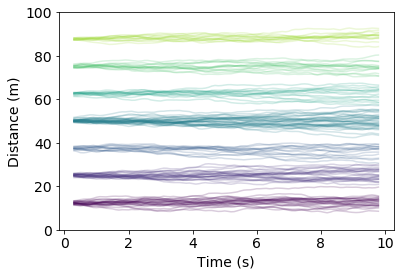

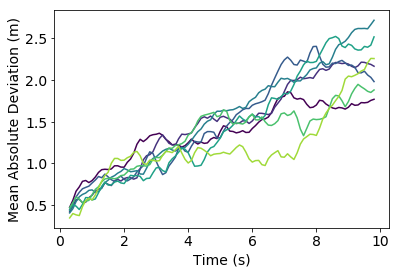

In [7]:
collected_data_file = 'Data/collected_drift_trials_v2_all.npy'
plot_keys_list = [45, 90, 135, 180, 225, 270, 315]
plot_key_units = 'm'
N_excitatory = 1024
synaptic_noise_amount = 0
plot_items_dict = pick_angle_data(collected_data_file, 
                                  plot_keys_list, 
                                  N_excitatory = N_excitatory, 
                                  synaptic_noise_amount = synaptic_noise_amount)

plt.rcParams.update({'font.size': 14}) # Change the font size
SAVE_PLOT = True

if SAVE_PLOT:
    title=''
else:
    title='Dispersion ($N_e$=' + str(N_excitatory) + ', synaptic_noise=' + str(synaptic_noise_amount) + ')'

figure_handles = plot_data_scaled_to_line(plot_items_dict, plot_keys_list, plot_key_units, title=title, show_legend=False)

if SAVE_PLOT:
    figure_handles[0].savefig('Data/Plots/' + 'dispersion_N1024' + '.png', bbox_inches='tight', dpi=300)
    figure_handles[0].savefig('Data/Plots/' + 'dispersion_N1024' + '.pdf', bbox_inches='tight', dpi=300)

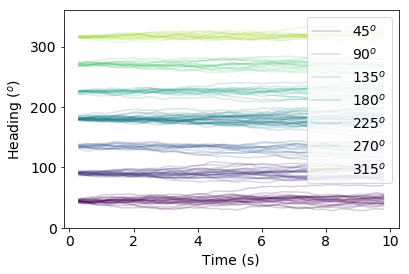

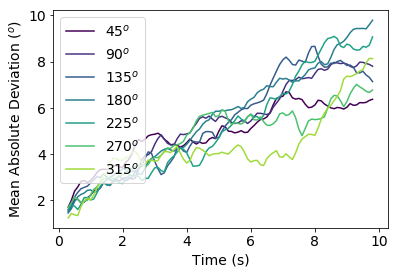

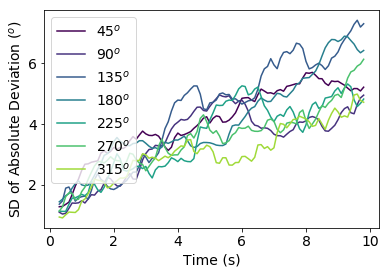

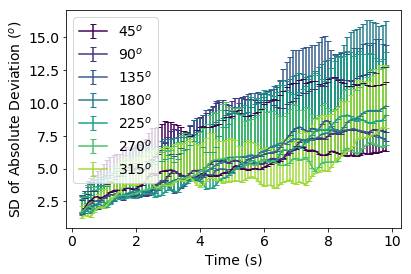

In [4]:
collected_data_file = 'Data/collected_drift_trials_v2_all.npy'
plot_keys_list = [45, 90, 135, 180, 225, 270, 315]
plot_key_units = '$^{o}$'
N_excitatory = 1024
synaptic_noise_amount = 0
plot_items_dict = pick_angle_data(collected_data_file, 
                                  plot_keys_list, 
                                  N_excitatory = N_excitatory, 
                                  synaptic_noise_amount = synaptic_noise_amount)
plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
          title='Dispersion ($N_e$=' + str(N_excitatory) + ', synaptic_noise=' + str(synaptic_noise_amount) + ')')

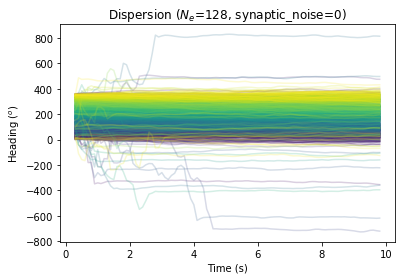

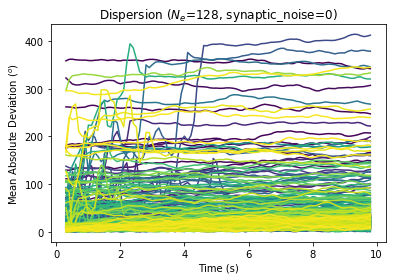

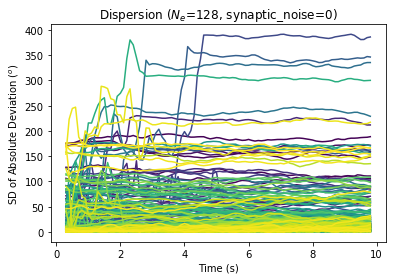

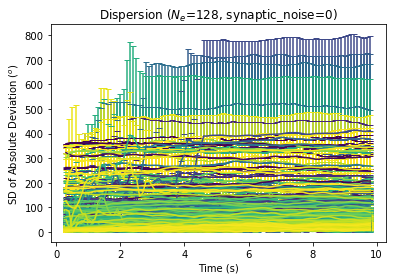

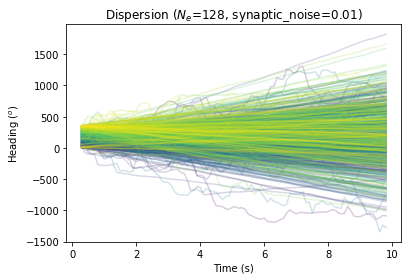

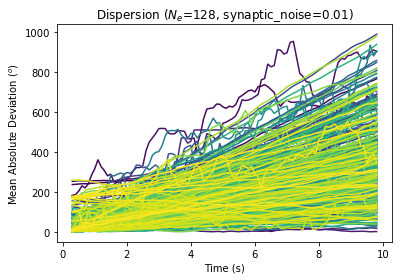

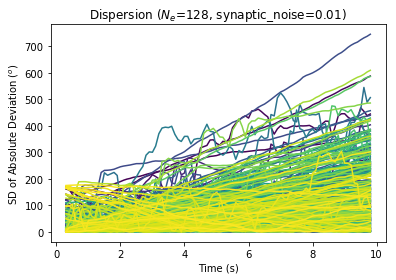

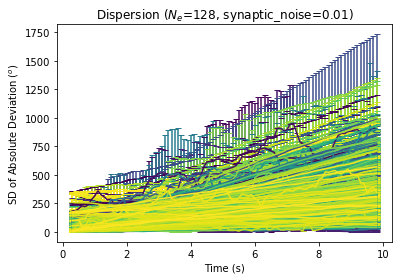

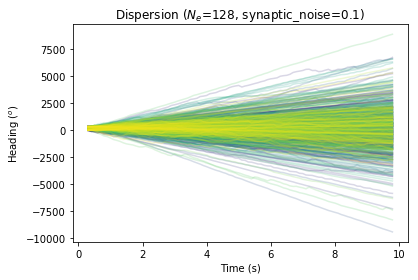

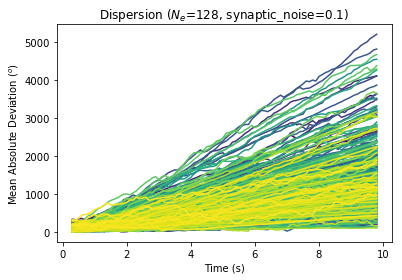

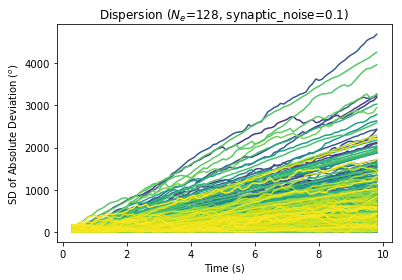

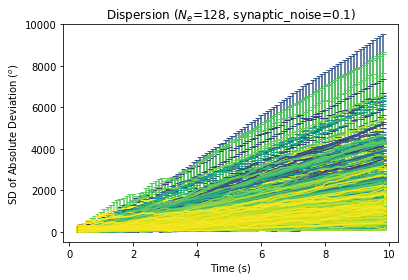

In [63]:
collected_data_file = 'Data/collected_drift_trials_v5-N128--heading0-1-360-t1.npy'
plot_keys_list = range(0, 360+1)
plot_key_units = '$^{o}$'
N_excitatory = 128
synaptic_noise_amount_list = [0, 0.01, 0.1]
for synaptic_noise_amount in synaptic_noise_amount_list:
    plot_items_dict = pick_angle_data(collected_data_file, 
                                      plot_keys_list, 
                                      N_excitatory = N_excitatory, 
                                      synaptic_noise_amount = synaptic_noise_amount, 
                                      unwrap_modulo_angles = True)
    plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
              ylim1 = None, 
              title='Dispersion ($N_e$=' + str(N_excitatory) + ', synaptic_noise=' + str(synaptic_noise_amount) + ')')

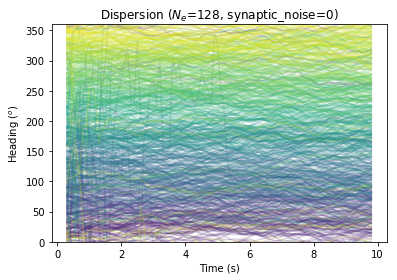

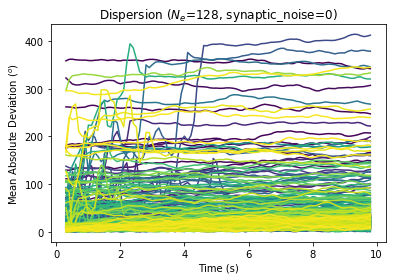

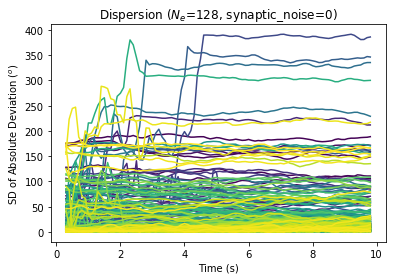

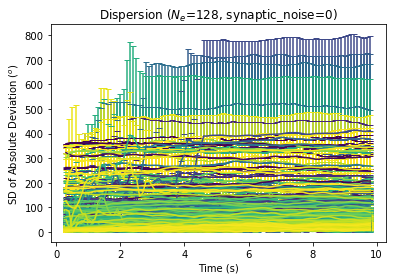

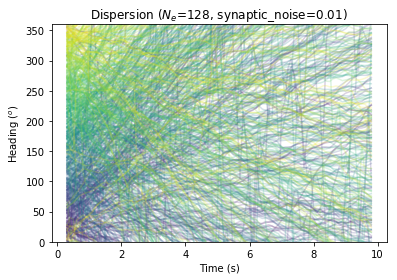

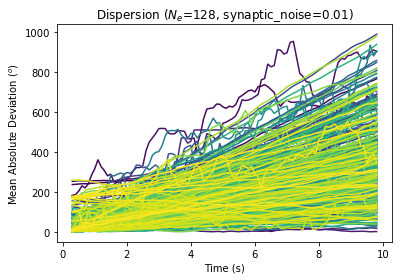

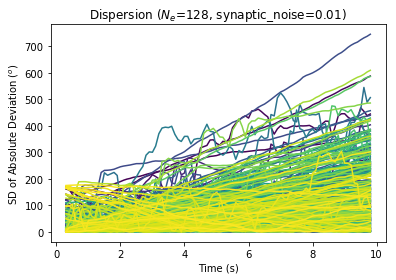

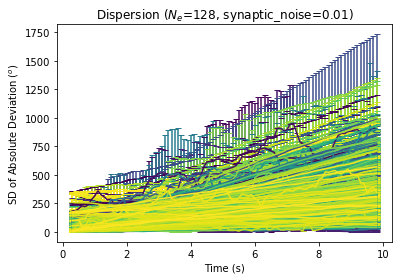

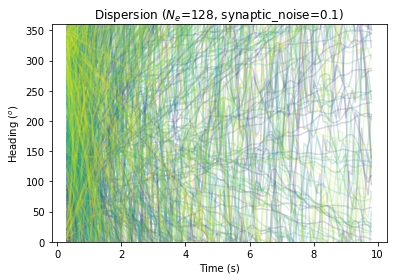

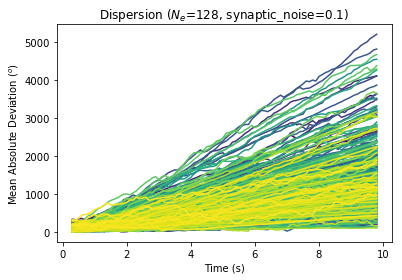

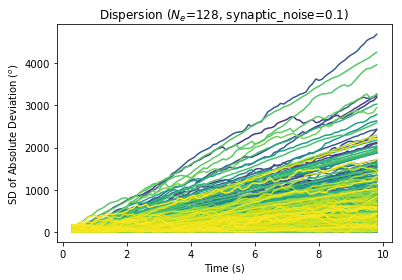

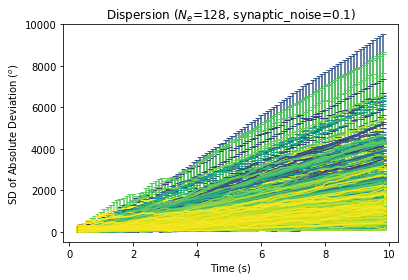

In [64]:
collected_data_file = 'Data/collected_drift_trials_v5-N128--heading0-1-360-t1.npy'
plot_keys_list = range(0, 360+1)
plot_key_units = '$^{o}$'
N_excitatory = 128
synaptic_noise_amount_list = [0, 0.01, 0.1]
for synaptic_noise_amount in synaptic_noise_amount_list:
    plot_items_dict = pick_angle_data(collected_data_file, 
                                      plot_keys_list, 
                                      N_excitatory = N_excitatory, 
                                      synaptic_noise_amount = synaptic_noise_amount, 
                                      unwrap_modulo_angles = True)
    plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
              #ylim1 = None, 
              title='Dispersion ($N_e$=' + str(N_excitatory) + ', synaptic_noise=' + str(synaptic_noise_amount) + ')')

### Dispersion for different network sizes

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

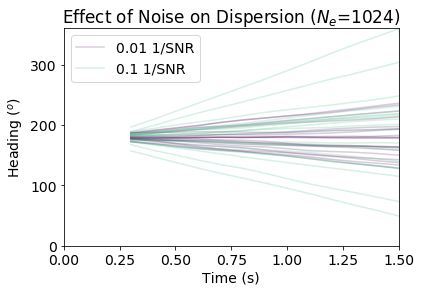

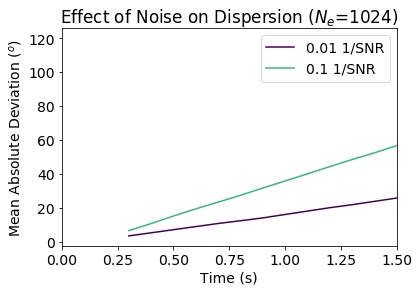

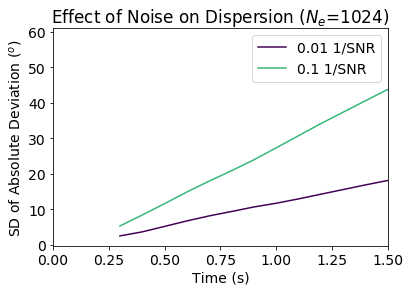

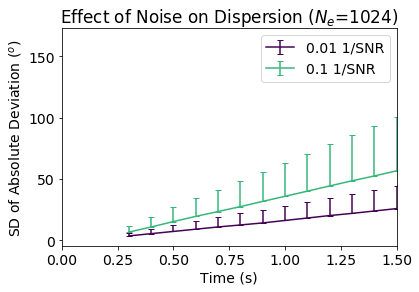

In [6]:
collected_data_file = 'Data/collected_drift_trials_v3and4_all.npy'

plot_keys_list = [0.01, 0.05, 0.1, 0.5]
plot_keys_list = [0.01, 0.05, 0.1]
plot_key_units = ' 1/SNR'
N_excitatory = 1024
stimulus_center_deg = 180
plot_items_dict = pick_noise_data(collected_data_file, 
                                  plot_keys_list, 
                                  N_excitatory = N_excitatory, 
                                  stimulus_center_deg = stimulus_center_deg)
plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
          xlim=[0, 1.5],
          title='Effect of Noise on Dispersion ($N_e$=' + str(N_excitatory) + ')')

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

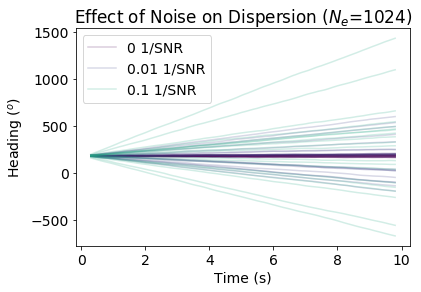

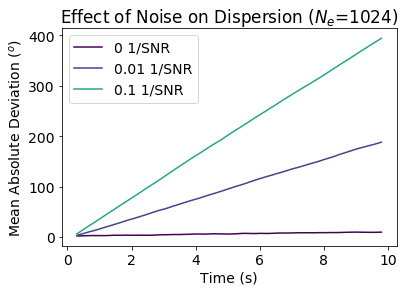

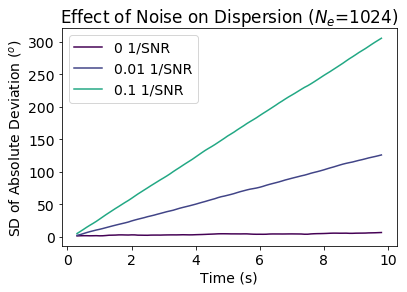

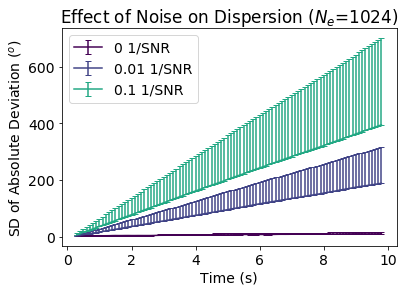

In [7]:
collected_data_file = 'Data/collected_drift_trials_v3and4_all.npy'

# The same with unwrapped modulo angles
plot_keys_list = [0, 0.01, 0.05, 0.1, 0.5]
#plot_keys_list = [0.01, 0.05, 0.1]
plot_key_units = ' 1/SNR'
N_excitatory = 1024
stimulus_center_deg = 180
plot_items_dict = pick_noise_data(collected_data_file, 
                                  plot_keys_list, 
                                  N_excitatory = N_excitatory, 
                                  stimulus_center_deg = stimulus_center_deg,
                                  unwrap_modulo_angles = True)
plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
          #xlim=[0, 1.5],
          ylim1 = None, #[-200, 1000],
          ylim2 = None, #[0, 100],
          title='Effect of Noise on Dispersion ($N_e$=' + str(N_excitatory) + ')')

### Effect of Net Size on Dispersion

Synaptic noise = 0

Synaptic noise = 0


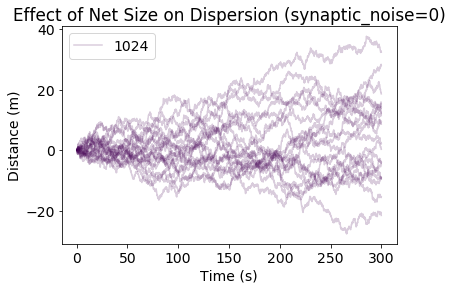

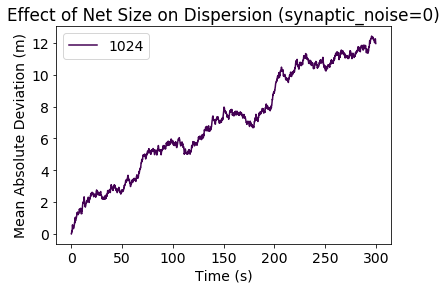

In [4]:
# Testing 1/N or sqrt(1/N) progression of error over time.
# Simulation duration 60s: Data/collected_drift_trials_v6-Ne1024-D60s.npy
# Data converted from circular degrees to linear meters
# Range 100m

SAVE_PLOT = False

plt.rcParams.update({'font.size': 14}) # Change the font size

collected_data_file = 'Data/collected_drift_trials_v6-Ne1024-D60s.npy' # Simulation duration 60s
collected_data_file = 'Data/collected_drift_trials_v6-Ne1024-D300s.npy' # Simulation duration 300s

#plot_keys_list = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
#plot_keys_list = [256, 512, 1024, 2048, 4096, 8192, 16384]
plot_keys_list = [1024]
plot_key_units = ' Excitatory neurons'
stimulus_center_deg = 180
synaptic_noise_amount = 0
print('Synaptic noise = {}'.format(synaptic_noise_amount))
plot_items_dict = pick_net_size_data(collected_data_file, 
                                     plot_keys_list, 
                                     stimulus_center_deg = stimulus_center_deg, 
                                     synaptic_noise_amount = synaptic_noise_amount,
                                     unwrap_modulo_angles = True)
if SAVE_PLOT:
    title = None
else:
    title='Effect of Net Size on Dispersion (synaptic_noise=' + str(synaptic_noise_amount) + ')'
figure_handles = plot_data_scaled_to_line(plot_items_dict, plot_keys_list, plot_key_units='', 
          scale=[(0, 360), (0, 100)], 
          normalise_start = 0, 
          ylim1 = None,
          #ylim2=[0, 100], 
          #xlim = [0, 8],
          title=title)

if SAVE_PLOT:
    figure_handles[1].savefig('Data/Plots/' + 'effect_of_net_size_on_dispersion_range100m-v6-Ne1024-D300s' + '.png', bbox_inches='tight', dpi=300)
    figure_handles[1].savefig('Data/Plots/' + 'effect_of_net_size_on_dispersion_range100m-v6-Ne1024-D300s' + '.pdf', bbox_inches='tight', dpi=300)

Synaptic noise = 0


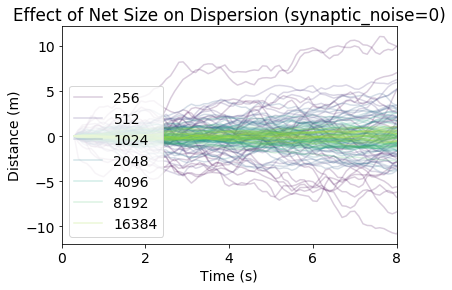

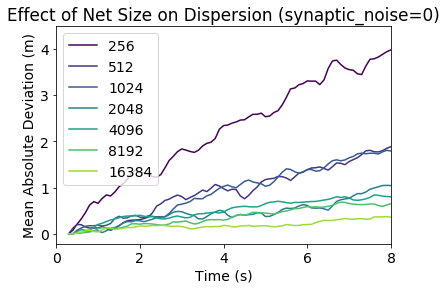

In [8]:
# Data converted from circular degrees to linear meters
# Range 100m

plt.rcParams.update({'font.size': 14}) # Change the font size

collected_data_file = 'Data/collected_drift_trials_v3and4_all.npy'

#plot_keys_list = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plot_keys_list = [256, 512, 1024, 2048, 4096, 8192, 16384]
plot_key_units = ' Excitatory neurons'
stimulus_center_deg = 180
synaptic_noise_amount = 0
print('Synaptic noise = {}'.format(synaptic_noise_amount))
plot_items_dict = pick_net_size_data(collected_data_file, 
                                     plot_keys_list, 
                                     stimulus_center_deg = stimulus_center_deg, 
                                     synaptic_noise_amount = synaptic_noise_amount,
                                     unwrap_modulo_angles = True)
if SAVE_PLOT:
    title = None
else:
    title='Effect of Net Size on Dispersion (synaptic_noise=' + str(synaptic_noise_amount) + ')'
figure_handles = plot_data_scaled_to_line(plot_items_dict, plot_keys_list, plot_key_units='', 
          scale=[(0, 360), (0, 100)], 
          normalise_start = 0, 
          ylim1 = None,
          #ylim2=[0, 100], 
          xlim = [0, 8],
          title=title)

if SAVE_PLOT:
    figure_handles[1].savefig('Data/Plots/' + 'effect_of_net_size_on_dispersion_range100m' + '.png', bbox_inches='tight', dpi=300)
    figure_handles[1].savefig('Data/Plots/' + 'effect_of_net_size_on_dispersion_range100m' + '.pdf', bbox_inches='tight', dpi=300)

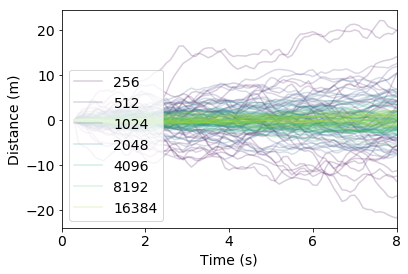

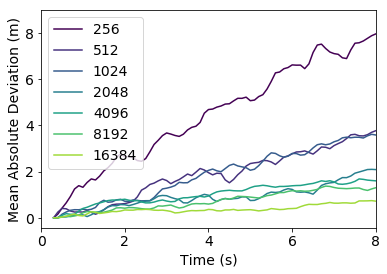

In [19]:
# Range 200m
plt.rcParams.update({'font.size': 14}) # Change the font size

figure_handles = plot_data_scaled_to_line(plot_items_dict, plot_keys_list, plot_key_units='', 
          scale=[(0, 360), (0, 200)], 
          normalise_start = 0, 
          ylim1 = None,
          #ylim2=[0, 100], 
          xlim=[0, 8], 
          title=title)
if SAVE_PLOT:
    figure_handles[1].savefig('Data/Plots/' + 'effect_of_net_size_on_dispersion_range200m' + '.png', bbox_inches='tight', dpi=300)
    figure_handles[1].savefig('Data/Plots/' + 'effect_of_net_size_on_dispersion_range200m' + '.pdf', bbox_inches='tight', dpi=300)

Synaptic noise = 0


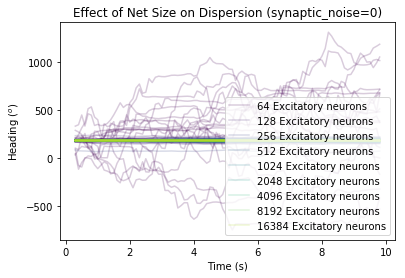

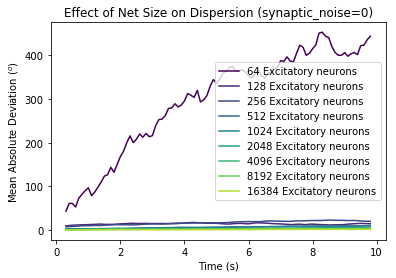

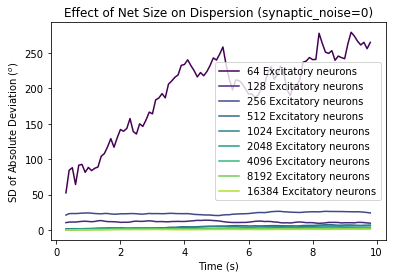

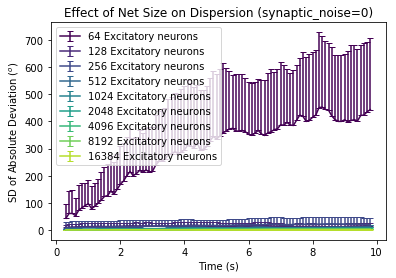

In [3]:
# Plot the original results of theta being circular degrees around the ring attractor

#collected_data_file = 'Data/collected_drift_trials_v2_all.npy'
collected_data_file = 'Data/collected_drift_trials_v3_all.npy'
collected_data_file = 'Data/collected_drift_trials_v3b_all.npy'
collected_data_file = 'Data/collected_drift_trials_v3and4_all.npy'

#plot_keys_list = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plot_keys_list = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plot_key_units = ' Excitatory neurons'
stimulus_center_deg = 180
synaptic_noise_amount = 0
print('Synaptic noise = {}'.format(synaptic_noise_amount))
plot_items_dict = pick_net_size_data(collected_data_file, 
                                     plot_keys_list, 
                                     stimulus_center_deg = stimulus_center_deg, 
                                     synaptic_noise_amount = synaptic_noise_amount,
                                     unwrap_modulo_angles = True)
plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
          ylim1 = None,
          #ylim2=[0, 360], 
          title='Effect of Net Size on Dispersion (synaptic_noise=' + str(synaptic_noise_amount) + ')')

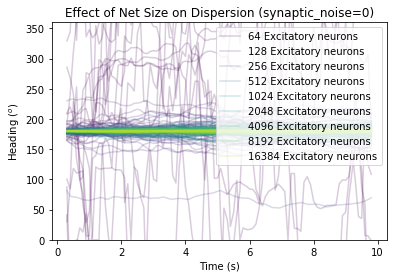

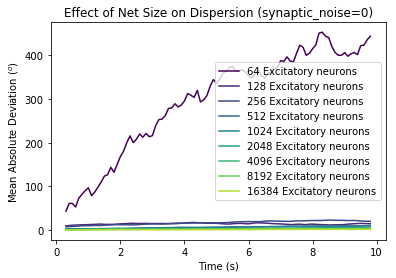

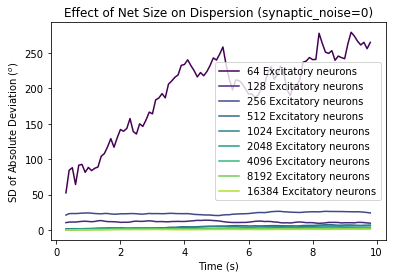

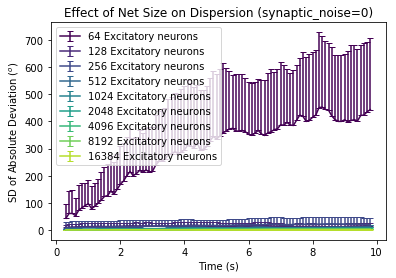

In [58]:
plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
          #ylim2=[0, 360], 
          title='Effect of Net Size on Dispersion (synaptic_noise=' + str(synaptic_noise_amount) + ')')

Synaptic noise = 0.01

Synaptic noise = 0.01


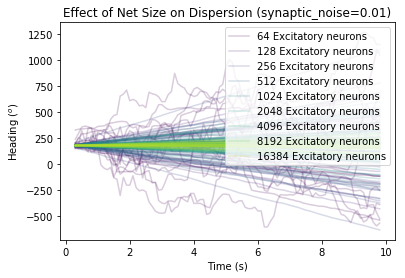

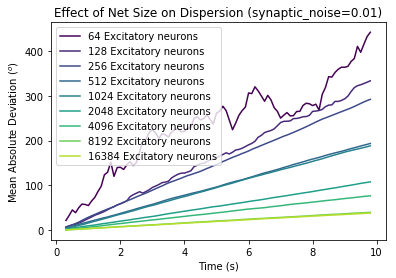

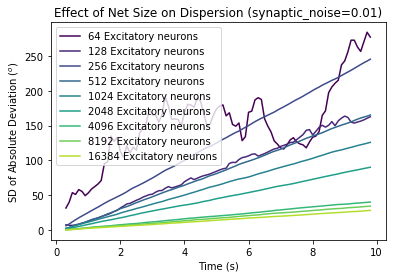

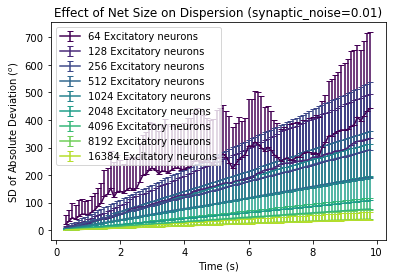

In [59]:
plot_keys_list = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plot_key_units = ' Excitatory neurons'
stimulus_center_deg = 180
synaptic_noise_amount = 0.01
print('Synaptic noise = {}'.format(synaptic_noise_amount))
plot_items_dict = pick_net_size_data(collected_data_file, 
                                     plot_keys_list, 
                                     stimulus_center_deg = stimulus_center_deg, 
                                     synaptic_noise_amount = synaptic_noise_amount,
                                     unwrap_modulo_angles = True)
plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
          #xlim=[0, 2],
          ylim1=None,
          #ylim2=[0, 360], 
          title='Effect of Net Size on Dispersion (synaptic_noise=' + str(synaptic_noise_amount) + ')')

Synaptic noise = 0.1

Synaptic noise = 0.1


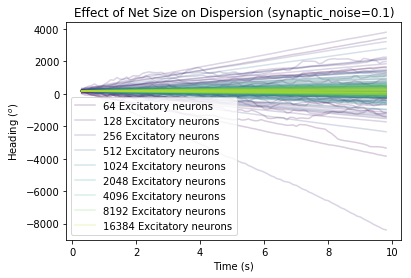

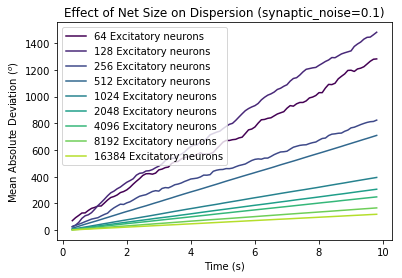

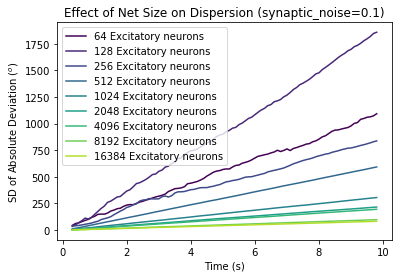

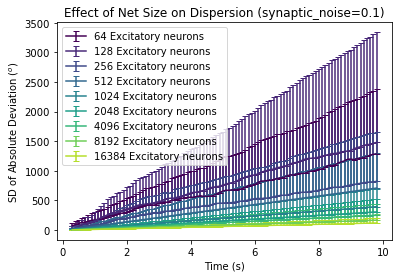

In [60]:
plot_keys_list = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plot_key_units = ' Excitatory neurons'
stimulus_center_deg = 180
synaptic_noise_amount = 0.1
print('Synaptic noise = {}'.format(synaptic_noise_amount))
plot_items_dict = pick_net_size_data(collected_data_file, 
                                     plot_keys_list, 
                                     stimulus_center_deg = stimulus_center_deg, 
                                     synaptic_noise_amount = synaptic_noise_amount,
                                     unwrap_modulo_angles = True)
plot_data(plot_items_dict, plot_keys_list, plot_key_units, 
          #xlim=[0, 2],
          ylim1 = None,
          #ylim2=[0, 360], 
          title='Effect of Net Size on Dispersion (synaptic_noise=' + str(synaptic_noise_amount) + ')')

Synaptic noise = 0
Neurons Drift rate
number    (°/s)   
     64 60.2266892106
    128 1.5198935672
    256 1.87794952612
    512 0.844504408026
   1024 0.838261657467
   2048 0.364996854342
   4096 0.468567125174
   8192 0.334752758182
  16384 0.131211712338
Neurons Drift rate
number  (units/s) 
     64 16.7296358918
    128 0.422192657555
    256 0.521652646145
    512 0.234584557785
   1024 0.232850460408
   2048 0.101388015095
   4096 0.13015753477
   8192 0.0929868772727
  16384 0.0364476978716
Synaptic noise = 0.01
Neurons Drift rate
number    (°/s)   
     64 47.9102774801
    128 30.9075159918
    256 28.0036083902
    512 18.4803420983
   1024 18.3310880526
   2048 10.1059943478
   4096 7.48332486233
   8192 3.97803894989
  16384 3.77225327376
Neurons Drift rate
number  (units/s) 
     64 13.3084104111
    128 8.58542110883
    256 7.77878010838
    512 5.13342836064
   1024 5.09196890351
   2048 2.80722065218
   4096 2.07870135065
   8192 1.10501081941
  16384 1.0478481316
Sy

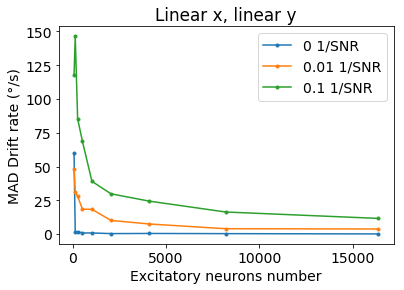

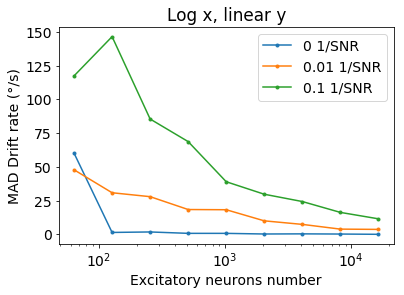

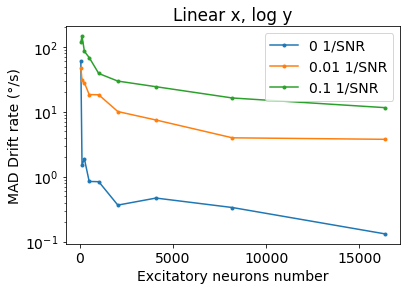

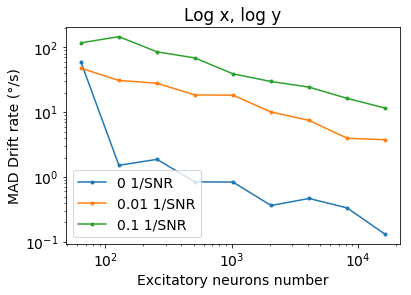

In [9]:
plot_keys_list = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plot_key_units = ' Excitatory neurons'
stimulus_center_deg = 180
synaptic_noise_amount_list = [0, 0.01, 0.1]
results_data = dict();
for synaptic_noise_amount in synaptic_noise_amount_list:
    print('Synaptic noise = {}'.format(synaptic_noise_amount))
    plot_items_dict = pick_net_size_data(collected_data_file, 
                                         plot_keys_list, 
                                         stimulus_center_deg = stimulus_center_deg, 
                                         synaptic_noise_amount = synaptic_noise_amount,
                                         unwrap_modulo_angles = True)


    plot_items_dict = calc_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, start_time=0, end_time=5)
    print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str='Neurons', plot_key_units='number')
    #print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str='Noise', plot_key_units='(1/SNR)')
    print_theta_mean_absolute_deviation_rate_scaled(plot_items_dict, plot_keys_list, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')
    
    # Collect data for plot
    results_data[synaptic_noise_amount] = dict()
    results_data[synaptic_noise_amount]['x'] = []
    results_data[synaptic_noise_amount]['y'] = []
    for plot_key in plot_keys_list:
        if plot_key in plot_items_dict:
            results_data[synaptic_noise_amount]['x'].append(plot_key)
            results_data[synaptic_noise_amount]['y'].append(plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'])
    
# Plot the collected data (linear-linear axis)
plt.figure()
for synaptic_noise_amount in synaptic_noise_amount_list:
    plt.plot(results_data[synaptic_noise_amount]['x'], results_data[synaptic_noise_amount]['y'], linestyle='-', marker='.', label=str(synaptic_noise_amount)+' 1/SNR')
    plt.legend()
    plt.xlabel('Excitatory neurons number')
    plt.ylabel('MAD Drift rate (°/s)')
    plt.title('Linear x, linear y')

# Plot the collected data (log x axis)
plt.figure()
for synaptic_noise_amount in synaptic_noise_amount_list:
    plt.plot(results_data[synaptic_noise_amount]['x'], results_data[synaptic_noise_amount]['y'], linestyle='-', marker='.', label=str(synaptic_noise_amount)+' 1/SNR')
    plt.legend()
    plt.xlabel('Excitatory neurons number')
    plt.ylabel('MAD Drift rate (°/s)')
    plt.xscale('log')
    plt.title('Log x, linear y')

# Plot the collected data (log y axis)
plt.figure()
for synaptic_noise_amount in synaptic_noise_amount_list:
    plt.plot(results_data[synaptic_noise_amount]['x'], results_data[synaptic_noise_amount]['y'], linestyle='-', marker='.', label=str(synaptic_noise_amount)+' 1/SNR')
    plt.legend()
    plt.xlabel('Excitatory neurons number')
    plt.ylabel('MAD Drift rate (°/s)')
    plt.yscale('log')
    plt.title('Linear x, log y')

# Plot the collected data (log x and y axis)
plt.figure()
for synaptic_noise_amount in synaptic_noise_amount_list:
    plt.plot(results_data[synaptic_noise_amount]['x'], results_data[synaptic_noise_amount]['y'], linestyle='-', marker='.', label=str(synaptic_noise_amount)+' 1/SNR')
    plt.legend()
    plt.xlabel('Excitatory neurons number')
    plt.ylabel('MAD Drift rate (°/s)')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Log x, log y')

WARNING    /Users/john/Library/Python/2.7/lib/python/site-packages/brian2/units/fundamentalunits.py:207: RuntimeWarning: overflow encountered in exp
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [4.28874167e+03 6.68316652e-02 6.94200993e-01]
R^2 = 0.999347662788
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [3.92940689e+01 2.08864988e-03 6.98118031e+00]
R^2 = 0.907376673454
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [1.26343797e+02 1.80950598e-03 1.93456793e+01]
R^2 = 0.931420244529


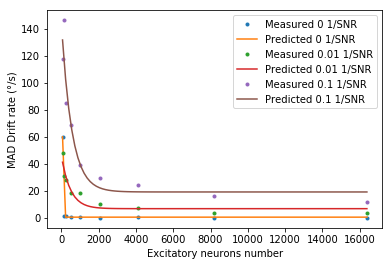

In [7]:
# Fit curves to the data points
import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y


for synaptic_noise_amount in synaptic_noise_amount_list:
    x = np.array(results_data[synaptic_noise_amount]['x'])
    y = np.array(results_data[synaptic_noise_amount]['y'])
        
    params0 = [0.1, 0.1, 0.1] # Initial guess of parameter values to optimize [a, b, c]
    params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters
    
    # Print the fitted parameters
    print('Optimal parameters')
    print('a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func_exp(x, params[0], params[1], params[2])
    
    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))
    
    # Plot data points
    plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(synaptic_noise_amount)+' 1/SNR')
    
    # Plot fitted curve for more sample points to make it smooth
    x_prime = np.linspace(np.min(x), np.max(x), num=100, endpoint=True)
    # Calculate fitted curve prediction
    y_prime = func_exp(x_prime, params[0], params[1], params[2])
    plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(synaptic_noise_amount)+' 1/SNR')
    
    plt.legend(loc='best')
    plt.xlabel('Excitatory neurons number')
    plt.ylabel('MAD Drift rate (°/s)')

    #plt.xscale('log')
    #plt.yscale('log')

Max tolerable drift rate 22.5°/h (0.00625°/s)
With synaptic noise level 0 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [3.14820195e+04 5.07611651e+00 2.24944964e+02]
R^2 = 0.934427197111
For ensuring drift of less than 22.5°/h (0.00625°/s) we need 30724 excitatory neurons

With synaptic noise level 0.01 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [5.11274019e+04 3.73203205e-01 4.65871429e+02]
R^2 = 0.884994251827
For ensuring drift of less than 22.5°/h (0.00625°/s) we need 51474 excitatory neurons

With synaptic noise level 0.1 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [6.87230980e+04 1.26941841e-01 3.52786994e+02]
R^2 = 0.994540049662
For ensuring drift of less than 22.5°/h (0.00625°/s) we need 69021 excitatory neurons



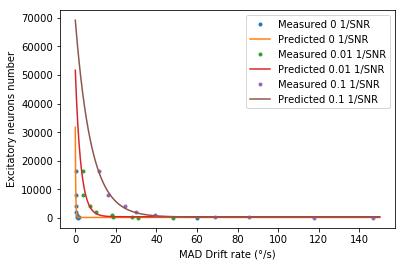

In [27]:
# Fit curves to the data points
# Drift rate in degrees/sec
import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

# Requirements calculation:
t_req = 60 * 60 # t_req = 1h
drift_max = 45 / 2 # drift_max = 45deg / 2 = 22.5deg
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}°/h ({}°/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y


for synaptic_noise_amount in synaptic_noise_amount_list:
    print('With synaptic noise level {} 1/SNR :'.format(synaptic_noise_amount))
    
    x = np.array(results_data[synaptic_noise_amount]['y'])
    y = np.array(results_data[synaptic_noise_amount]['x'])
        
    params0 = [10000, 0.1, 0.1] # Initial guess of parameter values to optimize [a, b, c]
    params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters
    
    # Print the fitted parameters
    print('Optimal parameters')
    print('a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func_exp(x, params[0], params[1], params[2])
    
    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))
    
    # Calculate required number of neurons
    y_req = func_exp(x_req, params[0], params[1], params[2])
    print('For ensuring drift of less than {}°/h ({}°/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
    
    # Plot data points
    plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(synaptic_noise_amount)+' 1/SNR')
    
    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    x_prime = np.linspace(0, 150, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_exp(x_prime, params[0], params[1], params[2])
    plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(synaptic_noise_amount)+' 1/SNR')
    
    # 
    
    plt.legend(loc='best')
    plt.xlabel('MAD Drift rate (°/s)')
    plt.ylabel('Excitatory neurons number')

    #plt.xscale('log')
    #plt.yscale('log')
    
    print()

Max tolerable drift rate 3.6m/h (0.001m/s)
With synaptic noise level 0 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [3.14820195e+04 5.07611651e+00 2.24944964e+02]
R^2 = 0.934427197111
For ensuring drift of less than 3.6m/h (0.001m/s) we need 31548 excitatory neurons

With synaptic noise level 0.01 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [5.11274019e+04 3.73203205e-01 4.65871429e+02]
R^2 = 0.884994251827
For ensuring drift of less than 3.6m/h (0.001m/s) we need 51574 excitatory neurons

With synaptic noise level 0.1 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [6.87230980e+04 1.26941841e-01 3.52786994e+02]
R^2 = 0.994540049662
For ensuring drift of less than 3.6m/h (0.001m/s) we need 69067 excitatory neurons



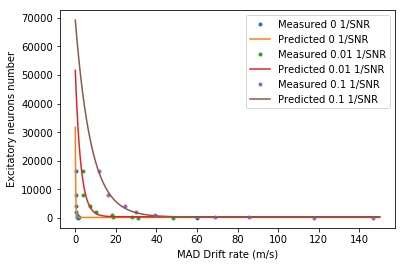

In [31]:
# Fit curves to the data points
# Drift rate in meters/sec

# Requirements calculation:
t_req = 60 * 60 # t_req = 1h
range_max = 360
drift_max_percent = 0.01 # 1/100
drift_max = drift_max_percent * range_max # drift_max = 1%, if full range is 100m then drift_max is 1m
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y


for synaptic_noise_amount in synaptic_noise_amount_list:
    print('With synaptic noise level {} 1/SNR :'.format(synaptic_noise_amount))
    
    x = np.array(results_data[synaptic_noise_amount]['y'])
    y = np.array(results_data[synaptic_noise_amount]['x'])
        
    params0 = [10000, 0.1, 0.1] # Initial guess of parameter values to optimize [a, b, c]
    params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters
    
    # Print the fitted parameters
    print('Optimal parameters')
    print('a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func_exp(x, params[0], params[1], params[2])
    
    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))
    
    # Calculate required number of neurons
    y_req = func_exp(x_req, params[0], params[1], params[2])
    print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
    
    # Plot data points
    plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(synaptic_noise_amount)+' 1/SNR')
    
    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    x_prime = np.linspace(0, 150, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_exp(x_prime, params[0], params[1], params[2])
    plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(synaptic_noise_amount)+' 1/SNR')
    
    # 
    
    plt.legend(loc='best')
    plt.xlabel('MAD Drift rate (m/s)')
    plt.ylabel('Excitatory neurons number')

    #plt.xscale('log')
    #plt.yscale('log')
    
    print()

Max tolerable drift rate 0.034m/h (9.44444444444e-06m/s)
With synaptic noise level 0 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [3.14820151e+04 1.82740159e+01 2.24944582e+02]
R^2 = 0.934427197111
For ensuring drift of less than 0.034m/h (9.44444444444e-06m/s) we need 31702 excitatory neurons
With synaptic noise level 0.01 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [5.11228224e+04 1.34344604e+00 4.65810505e+02]
R^2 = 0.884994251751
For ensuring drift of less than 0.034m/h (9.44444444444e-06m/s) we need 51588 excitatory neurons
With synaptic noise level 0.1 1/SNR :
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [6.87230130e+04 4.56990260e-01 3.52785765e+02]
R^2 = 0.994540049662
For ensuring drift of less than 0.034m/h (9.44444444444e-06m/s) we need 69076 excitatory neurons
Optimal parameters
y=a*exp(-b*x)+c, [a, b, c] = [3.14820080e+04 1.82740099e+01 2.24943868e+02]
R^2 = 0.934427197111
For ensuring drift of less than 0.034m/h (9.44444444444e-06m/s) we need 31702 exc

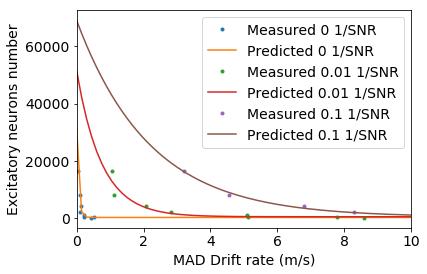

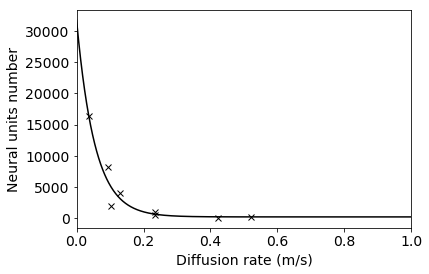

In [13]:
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

for synaptic_noise_amount in synaptic_noise_amount_list:
    print('With synaptic noise level {} 1/SNR :'.format(synaptic_noise_amount))
    
    x = np.array(results_data[synaptic_noise_amount]['y'])
    y = np.array(results_data[synaptic_noise_amount]['x'])
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    params0 = [10000, 0.1, 0.1] # Initial guess of parameter values to optimize [a, b, c]
    params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters
    
    # Print the fitted parameters
    print('Optimal parameters')
    print('a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func_exp(x, params[0], params[1], params[2])
    
    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))
    
    # Calculate required number of neurons
    y_req = func_exp(x_req, params[0], params[1], params[2])
    print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
    
    # Plot data points
    plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(synaptic_noise_amount)+' 1/SNR')
    
    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    x_prime = np.linspace(0, 150, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_exp(x_prime, params[0], params[1], params[2])
    plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(synaptic_noise_amount)+' 1/SNR')
    
    # 
    
    plt.legend(loc='best')
    plt.xlabel('MAD Drift rate (m/s)')
    plt.ylabel('Excitatory neurons number')
    plt.xlim([0, 10])
    
    #plt.xscale('log')
    #plt.yscale('log')
    
# Plot again only for 0 synaptic noise
plt.figure()
synaptic_noise_amount = 0

x = np.array(results_data[synaptic_noise_amount]['y'])
y = np.array(results_data[synaptic_noise_amount]['x'])
x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])

params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters

# Print the fitted parameters
print('Optimal parameters')
print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))

# Calculate fitted curve prediction
y_prime = func_exp(x, params[0], params[1], params[2])

# Calculate r^2
print('R^2 = {}'.format(r2_score(y, y_prime)))

# Calculate required number of neurons
y_req = func_exp(x_req, params[0], params[1], params[2])
print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

# Plot data points
#plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(synaptic_noise_amount)+' 1/SNR')
plt.plot(x, y, 'xk', label='Measured ' + str(synaptic_noise_amount)+' 1/SNR')

# Plot fitted curve for more sample points to make it smooth
#x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
max_lim = 1
x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)

# Calculate fitted curve prediction
y_prime = func_exp(x_prime, params[0], params[1], params[2])
#plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(synaptic_noise_amount)+' 1/SNR')
plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(synaptic_noise_amount)+' 1/SNR')

# 
#plt.legend(loc='best')
plt.xlabel('Diffusion rate (m/s)')
plt.ylabel('Neural units number')
plt.xlim([0, max_lim])
SAVE_PLOT = False
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '.pdf', bbox_inches='tight', dpi=300)

Effect of Time Constant on Diffusion
------------------------------------------

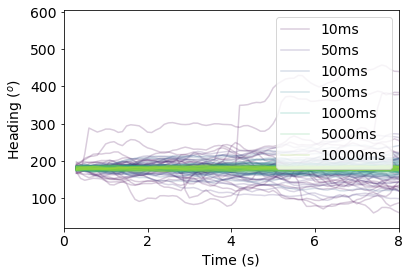

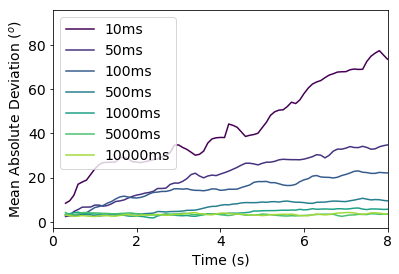

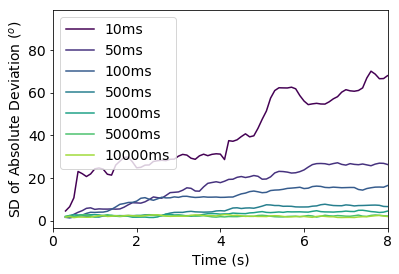

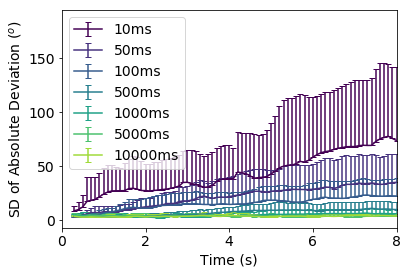

In [27]:
# Dataset collected with simplified neuron model
collected_data_file = 'Data/collected_drift_trials_v7-Ne1024-D10s-tau_m10ms-10s.npy'

SAVE_PLOT = False


# With unwrapped modulo angles
plot_keys_list = [10, 50, 100, 500, 1000, 5000, 10000] * ms
plot_key_units = 'ms'
N_excitatory = 1024
stimulus_center_deg = 180

plt.rcParams.update({'font.size': 14}) # Change the font size

plot_items_dict = pick_tau_data(collected_data_file, 
                                  N_excitatory = N_excitatory, 
                                  stimulus_center_deg = stimulus_center_deg,
                                  tau_excit_list = plot_keys_list, 
                                  unwrap_modulo_angles = True)

if SAVE_PLOT:
    title = ''
else:
    title='Effect of tau on Dispersion ($N_e$=' + str(N_excitatory) + ')'
    
figure_handles = plot_data(plot_items_dict, (plot_keys_list / ms).astype(int), plot_key_units, 
          xlim=[0, 8],
          ylim1 = None, #[-200, 1000],
          ylim2 = None, #[0, 100],
          title=title)

if SAVE_PLOT:
    figure_handles[1].savefig('Data/Plots/' + 'tau_vs_dispersion_rate_range' + '.png', bbox_inches='tight', dpi=300)
    figure_handles[1].savefig('Data/Plots/' + 'tau_vs_dispersion_rate_range' + '.pdf', bbox_inches='tight', dpi=300)

Adding noise
---------------

Variables of interest 
presyn_weight_kernel
Jpos_excit2excit
Jneg_excit2excit

andpossibly the weight variables of the inputs input_ext2excit and input_ext2inhib

$tmp = \sqrt{2\pi} \times sigma\_weight\_profile \times \frac{erf(\frac{\frac{180}{\sqrt{2}}}{sigma\_weight\_profile})}{360}$

$J_{neg\_excit2excit} = \frac{1 - J_{pos\_excit2excit} \times tmp}{1 - tmp}$


$for ~ j ~ in ~ (0, N_{excitatory}): \\ ~~~~ presyn\_weight\_kernel_j = J_{neg\_excit2excit} +  (J_{pos\_excit2excit} - J_{neg\_excit2excit}) * 
exp(\frac{-0.5 \times (\frac{360 \times min(j, N_{excitatory} - j)}{N_{excitatory}})^2}{sigma\_weight\_profile^2)})
$


    tmp = math.sqrt(2. * math.pi) * sigma_weight_profile * erf(180. / math.sqrt(2.) / sigma_weight_profile) / 360.
    Jneg_excit2excit = (1. - Jpos_excit2excit * tmp) / (1. - tmp)
    presyn_weight_kernel = \
        [(Jneg_excit2excit +
          (Jpos_excit2excit - Jneg_excit2excit) *
          math.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / sigma_weight_profile ** 2))
         for j in range(N_excitatory)]


With noise
----------

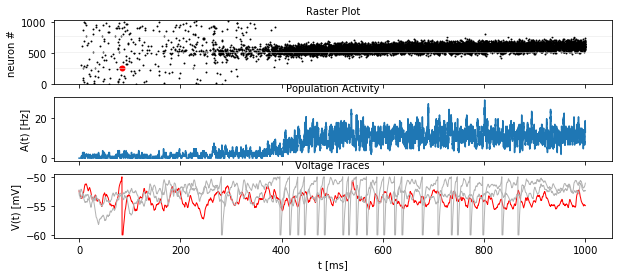

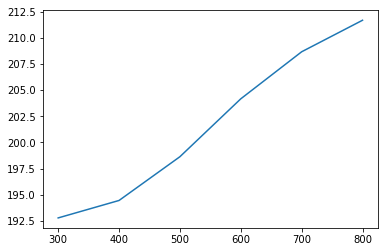

In [7]:
# Example how to create an array of timestamps spaced by snapshot_interval in the interval of interest.
stimulus_center_deg = 180
stimulus_width_deg  = 30
stimulus_strength   = .06 * namp
t_stimulus_start    = 100 * ms
t_stimulus_duration = 200 * ms
sim_time_duration   = 1000. * ms
t_window_width      = 200*ms
snapshot_interval   = 100*ms
N_excitatory = 1024
synaptic_noise_amount = 0.1

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model_modified.simulate_wm(stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration, synaptic_noise_amount=synaptic_noise_amount)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)
plt.show()

t_snapshots = range(
    int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
    int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
    int(round(snapshot_interval/ms))  # spacing between time stamps
    )*ms

# how your function get_theta_time_series could be called:
#theta_ts = get_theta_time_series(spike_monitor_excit, idx_monitored_neurons_excit, N_excitatory, t_snapshots, t_window_width)
theta_ts_v_a = get_theta_time_series_vec_add(spike_monitor_excit, idx_monitored_neurons_excit, N_excitatory, t_snapshots, t_window_width)
theta_ts_v_a = theta_ts_v_a[1]

# plot theta vs time using pyplot
plt.figure()
#plt.plot(t_snapshots/ms, theta_ts)
plt.plot(t_snapshots/ms, theta_ts_v_a)

# Plot the data from the Cataglyphis fortis homing accuracy papers

In [65]:
def explore_param_variations(title, x_points, y_points, params_v_copy, params_variations_map):
    """
        Plots the variations of the curve fitted to the data points 
        by varying each curve parameter by a range of percentages.
        Parameters:
        title                 : Title to show as first part of title in plots.
        x_points              : List of x data points.
        y_points              : List of y data points.
        params_v_copy         : Optimal parameters of fitted curve function.
        params_variations_map : Dict of ranges to vary each model parameter in percent. 
    """
    from IPython.display import display, Math

    params_v = params_v_copy.copy()

    # Print the fitted 
    print('Optimal parameters')
    if fit_func_name == 'func_slowthenfastdecay':
        display(Math(r'y = a - e^{(x / b)}' + ', [a, b] = [{:.3f}, {:.3f}]'.format(*params_v)))
    if fit_func_name == 'func_parabola':
        display(Math(r'y = ax^2 + bx + c, [a, b, c] = [{:.3f}, {:.3f}, {:.3f}]'.format(*params_v)))
    if fit_func_name == 'func_sigmoid_logistic_modified':
        display(Math(r'y = \frac{a}{1 + e^{k * (x - x0)}}' + ', [a, x0, k] = [{:.3f}, {:.3f}, {:.3f}]'.format(*params_v)))


    viridis = plt.cm.get_cmap('viridis')

    # Fit a fitted curves
    for i in range(len(params_v_copy)):
        fig = plt.figure()
        # Plot data points
        #plot(x_points, y_points, 'xk', alpha=1.00)

        variations_min, variations_max, variations_step = params_variations_map[i]
        variations_list = range(variations_min, variations_max, variations_step)
        num_of_colors = len(variations_list)
        for v_i, v in enumerate(variations_list):
            params_v = params_v_copy.copy()
            params_v[i] = params_v[i] + params_v[i] * v/100.0

            # Calculate fitted curve prediction
            x_prime = np.linspace(x_points[0], x_points[-1]*2, num=200)
            if fit_func_name == 'func_slowthenfastdecay':
                y_prime = fit_func(x_prime, params_v[0], params_v[1])
            if fit_func_name == 'func_parabola':
                y_prime = fit_func(x_prime, params_v[0], params_v[1], params_v[2])
            if fit_func_name == 'func_sigmoid_logistic_modified':
                y_prime = fit_func(x_prime, params_v[0], params_v[1], params_v[2])

            color = viridis(v_i/num_of_colors)
            plot(x_prime, y_prime, '-', color=mcolors.to_rgba(color, alpha=1))
            if v == 0:
                plot(x_prime, y_prime, '-k')

        # Plot data points above the fitted curves
        plot(x_points, y_points, 'xk', alpha=1.00)

        plt.ylabel('Median distance (m)')
        plt.xlabel('Time in captivity (hours)')
        plt.ylim([0, None])
        if not SAVE_PLOT:
            plt.title(title + ', param[' + str(i) + '] @ [' + str(variations_min) + ', ' + str(variations_max) + ']')
        plt.show




Optimal parameters
y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = [1.27911164e+01 2.19699124e+02 2.20667915e-02]
Optimal parameters
y = a * x + b, [a, b] = [0.03422619 1.14285714]
a = 0.034m/hour


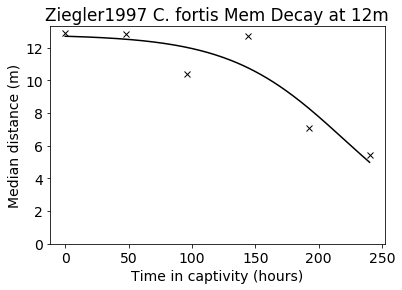

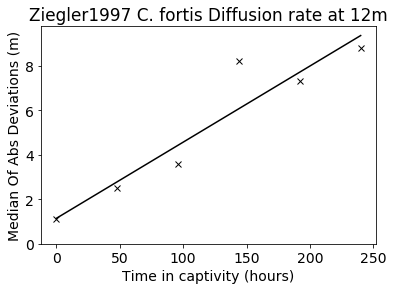

In [66]:
# Plot data from [11] Ziegler, P. E. and Wehner, R. Time-courses of memory decay in vector-based and landmark-based systems of navigation in desert ants, Cataglyphis fortis. 1997.
# Plots the Median homing distance and the Median Of Abs Deviations

SAVE_PLOT = False
plt.rcParams.update({'font.size': 14}) # Change the font size

# Data from paper
DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
HoursInCaptivity = DaysInCaptivity * 24
Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])

# Store variables for later
Z_HoursInCaptivity = HoursInCaptivity
Z_Homing_Distance_Median_12m = Homing_Distance_Median_12m

# Functions to use for regression to data
def func_linear(x, a, b):
    """ Linear function """
    y = a * x + b
    return y

def func_slowthenfastdecay(x, a, b):
    """ Decaying anti-exponential function """
    y = a - exp(x / b)
    return y

# Functions to use for regression to data
def func_parabola(x, a, b, c):
    """ Linear function """
    y = a * x**2 + b * x + c
    return y

def func_sigmoid_logistic_modified(x, a, x0, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    #return a * (1 - 1 / (1 + np.exp(-k * (x - x0))))
    return a / (1 + np.exp(k * (x - x0)))


# Select function to fit:
# -----------------------------------------------
# Function to fit 1
fit_func_name = 'func_slowthenfastdecay'
# Function to fit 2
#fit_func_name = 'func_parabola'
# Function to fit 3
fit_func_name = 'func_sigmoid_logistic_modified'
# -----------------------------------------------

if fit_func_name == 'func_slowthenfastdecay':
    fit_func = func_slowthenfastdecay
if fit_func_name == 'func_parabola':
    fit_func = func_parabola
if fit_func_name == 'func_sigmoid_logistic_modified':
    fit_func = func_sigmoid_logistic_modified

fig = plt.figure()
# Plot data points: Median homing distance
plot(HoursInCaptivity, Homing_Distance_Median_12m, 'xk')

# Fit a curve: Decaying anti-exponential function to the Homing_Distance_Median
x = HoursInCaptivity
y = Homing_Distance_Median_12m
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [12, 200, 1] # Initial guess of parameter values to optimize [a, x0, k]

params, conv  = curve_fit(fit_func, x, y, params0) # fit function parameters
Z_Homing_Distance_Median_12m_params = params.copy()
# Print the fitted parameters
print('Optimal parameters')
if fit_func_name == 'func_slowthenfastdecay':
    print('y = a - exp(x / b), [a, b] = {}'.format(params))
if fit_func_name == 'func_parabola':
    print('y = ax^2 + bx + c, [a, b, c] = {}'.format(params))
if fit_func_name == 'func_sigmoid_logistic_modified':
    print('y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'.format(params))

# Calculate fitted curve prediction
x_prime = np.linspace(HoursInCaptivity[0], HoursInCaptivity[-1], num=200)
if fit_func_name == 'func_slowthenfastdecay':
    y_prime = fit_func(x_prime, params[0], params[1])
if fit_func_name == 'func_parabola':
    y_prime = fit_func(x_prime, params[0], params[1], params[2])
if fit_func_name == 'func_sigmoid_logistic_modified':
    y_prime = fit_func(x_prime, params[0], params[1], params[2])
    
plot(x_prime, y_prime, '-k')
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Mem Decay at 12m')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.pdf', bbox_inches='tight', dpi=300)
plt.show
# Store variables for later
Z_x_prime_12m = x_prime
Z_y_prime_12m = y_prime

#plot(HoursInCaptivity, Homing_Distance_MAD_12m, '.-', label='MAD')

# Plot data points
fig = plt.figure()
plot(HoursInCaptivity, Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m, 'xk')

# Fit a curve: Line to the Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m
x = HoursInCaptivity
y = Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m
params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
params, conv  = curve_fit(func_linear, x, y, params0) # fit function parameters
# Print the fitted parameters
print('Optimal parameters')
print('y = a * x + b, [a, b] = {}'.format(params))
print('a = {:.3f}m/hour'.format(params[0]))
# Calculate fitted curve prediction
y_prime = func_linear(x, params[0], params[1])
plot(x, y_prime, '-k')
plt.ylabel('Median Of Abs Deviations (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Diffusion rate at 12m')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviations' + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviations' + '.pdf', bbox_inches='tight', dpi=300)

Optimal parameters


<IPython.core.display.Math object>

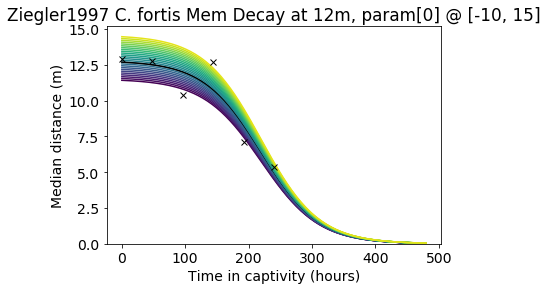

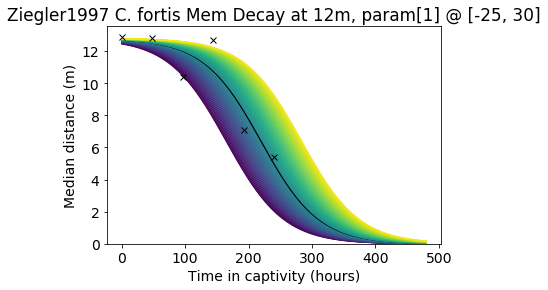

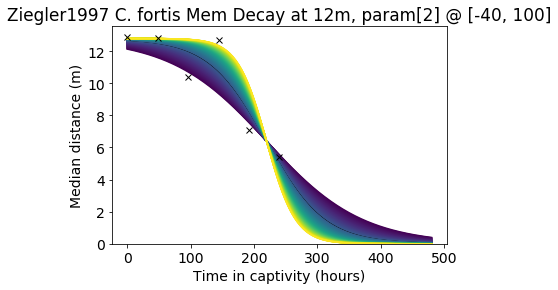

In [76]:
# Display fitted curves to the data points by varying model parameters
explore_param_variations(title = 'Ziegler1997 C. fortis Mem Decay at 12m',
                         x_points = Z_HoursInCaptivity.copy(), 
                         y_points = Z_Homing_Distance_Median_12m.copy(), 
                         params_v_copy = Z_Homing_Distance_Median_12m_params.copy(), 
                         params_variations_map = { # Variation is minus, plus, and step percentage
                            0 : (-10, 15, 1),
                            1 : (-25, 30, 1),
                            2 : (-40, 100, 1)
                         }
)

Optimal parameters
y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = [1.17441627e+01 1.15961086e+02 4.00000000e-02]


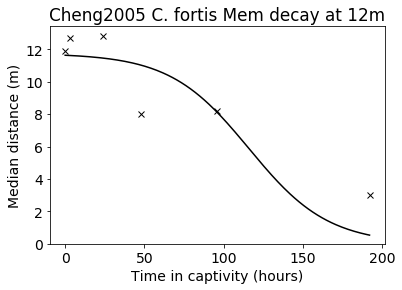

Optimal parameters
y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = [7.02651026e+00 1.50000000e+02 5.00000000e-02]


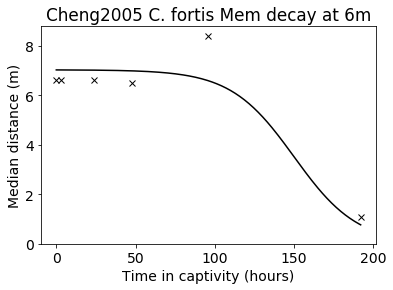

In [77]:
# Plot data from [1] Cheng, Ken, Narendra, Ajay, Wehner, Rüdiger, Behavioral ecology of odometric memories in desert ants: Acquisition, retention, and integration, 2005.
# Plots the Median homing distance (this paper has no Median Of Abs Deviations)

plt.rcParams.update({'font.size': 14}) # Change the font size

# Data from paper
HoursInCaptivity = np.array([0, 3, 24, 48, 96, 192])
Homing_Distance_Median_12m=np.array([11.9, 12.7, 12.8, 8.0, 8.2, 3.0])
Homing_Distance_CV_12m=np.array([0.21, 0.26, 0.34, 0.54, 0.64, 0.89])
Homing_Distance_Median_6m=np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
Homing_Distance_CV_6m=np.array([0.38, 0.28, 0.62, 0.55, 0.64, 1.41])


# Store variables for later
C_HoursInCaptivity = HoursInCaptivity
C_Homing_Distance_Median_12m = Homing_Distance_Median_12m
C_Homing_Distance_Median_6m = Homing_Distance_Median_6m

# Plot data points: Median homing distance
fig = plt.figure()
plot(HoursInCaptivity, Homing_Distance_Median_12m, 'xk', label='Median distance')

# Fit a curve: Decaying anti-exponential function to the Homing_Distance_Median_12m
x = HoursInCaptivity
y = Homing_Distance_Median_12m
bounds = [-inf, inf]
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [12, 100, 0.1] # Initial guess of parameter values to optimize [a, x0, k]
    bounds = [[0, 50, 0.04], [20, 150, 0.1]]
    
params, conv  = curve_fit(fit_func, x, y, params0, bounds = bounds) # fit function parameters
C_Homing_Distance_Median_12m_params = params.copy()
# Print the fitted parameters
print('Optimal parameters')
if fit_func_name == 'func_slowthenfastdecay':
    print('y = a - exp(x / b), [a, b] = {}'.format(params))
if fit_func_name == 'func_parabola':
    print('y = ax^2 + bx + c, [a, b, c] = {}'.format(params))
if fit_func_name == 'func_sigmoid_logistic_modified':
    print('y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'.format(params))


# Calculate fitted curve prediction
x_prime = np.linspace(HoursInCaptivity[0], HoursInCaptivity[-1], num=200)
if fit_func_name == 'func_slowthenfastdecay':
    y_prime = fit_func(x_prime, params[0], params[1])
if fit_func_name == 'func_parabola':
    y_prime = fit_func(x_prime, params[0], params[1], params[2])
if fit_func_name == 'func_sigmoid_logistic_modified':
    y_prime = fit_func(x_prime, params[0], params[1], params[2])

plot(x_prime, y_prime, '-k', label='Median distance Fit')
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Cheng2005 C. fortis Mem decay at 12m')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.pdf', bbox_inches='tight', dpi=300)
plt.show()
# Store variables for later
C_x_prime_12m = x_prime
C_y_prime_12m = y_prime

# plot(HoursInCaptivity, Homing_Distance_MAD_12m, '.-', label='CV')


# Plot data points: Median homing distance
fig = plt.figure()
plot(HoursInCaptivity, Homing_Distance_Median_6m, 'xk', label='Median distance')

# Fit a curve: Decaying anti-exponential function to the Homing_Distance_Median_6m
x = HoursInCaptivity
y = Homing_Distance_Median_6m
bounds = [-inf, inf]
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [6, 100, 0.01] # Initial guess of parameter values to optimize [a, x0, k]
    bounds = [[0, 50, 0.01], [20, 150, 0.05]]

params, conv  = curve_fit(fit_func, x, y, params0, bounds = bounds) # fit function parameters
C_Homing_Distance_Median_6m_params = params.copy()
# Print the fitted parameters
print('Optimal parameters')
if fit_func_name == 'func_slowthenfastdecay':
    print('y = a - exp(x / b), [a, b] = {}'.format(params))
if fit_func_name == 'func_parabola':
    print('y = ax^2 + bx + c, [a, b, c] = {}'.format(params))
if fit_func_name == 'func_sigmoid_logistic_modified':
    print('y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'.format(params))

# Calculate fitted curve prediction
x_prime = np.linspace(HoursInCaptivity[0], HoursInCaptivity[-1], num=200)
if fit_func_name == 'func_slowthenfastdecay':
    y_prime = fit_func(x_prime, params[0], params[1])
if fit_func_name == 'func_parabola':
    y_prime = fit_func(x_prime, params[0], params[1], params[2])
if fit_func_name == 'func_sigmoid_logistic_modified':
    y_prime = fit_func(x_prime, params[0], params[1], params[2])

plot(x_prime, y_prime, '-k', label='Median distance Fit')
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Cheng2005 C. fortis Mem decay at 6m')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_6m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_6m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.pdf', bbox_inches='tight', dpi=300)
# Store variables for later
C_x_prime_6m = x_prime
C_y_prime_6m = y_prime


Optimal parameters


<IPython.core.display.Math object>

Optimal parameters


<IPython.core.display.Math object>

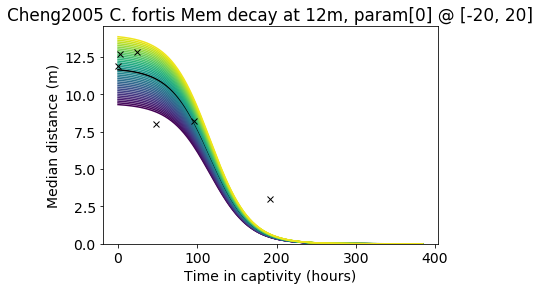

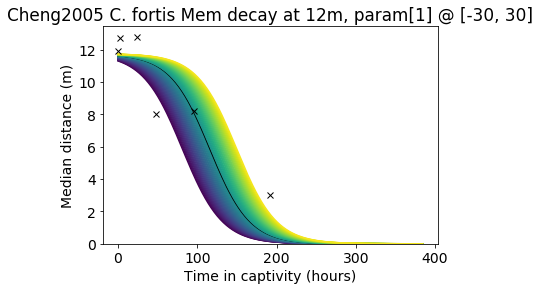

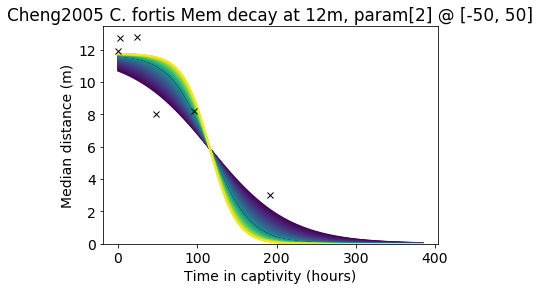

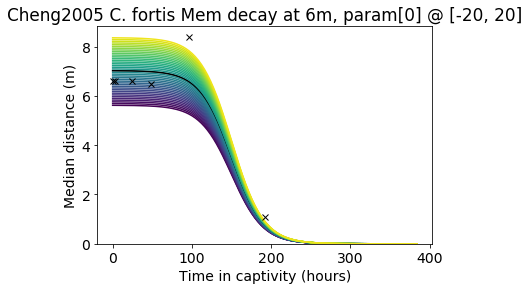

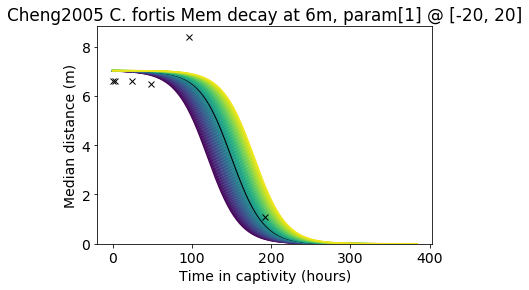

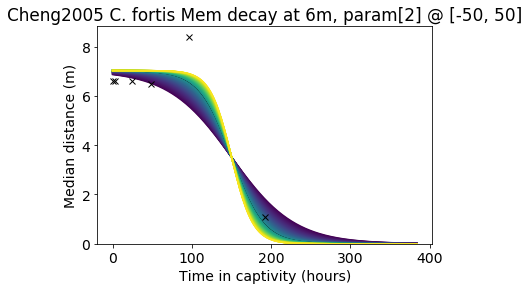

In [79]:
# Display fitted curves to the data points by varying model parameters
explore_param_variations(title = 'Cheng2005 C. fortis Mem decay at 12m',
                         x_points = C_HoursInCaptivity.copy(), 
                         y_points = C_Homing_Distance_Median_12m.copy(), 
                         params_v_copy = C_Homing_Distance_Median_12m_params.copy(), 
                         params_variations_map = { # Variation is minus, plus, and step percentage
                            0 : (-20, 20, 1),
                            1 : (-30, 30, 1),
                            2 : (-50, 50, 1)
                         }
)

# Display fitted curves to the data points by varying model parameters
explore_param_variations(title = 'Cheng2005 C. fortis Mem decay at 6m',
                         x_points = C_HoursInCaptivity.copy(), 
                         y_points = C_Homing_Distance_Median_6m.copy(), 
                         params_v_copy = C_Homing_Distance_Median_6m_params.copy(), 
                         params_variations_map = { # Variation is minus, plus, and step percentage
                            0 : (-20, 20, 1),
                            1 : (-20, 20, 1),
                            2 : (-50, 50, 1)
                         }
)

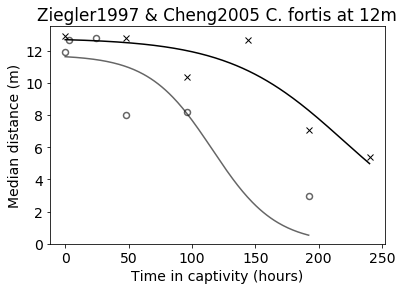

In [70]:
# Plots again the Median homing distance for both papers in one plot

plt.rcParams.update({'font.size': 14}) # Change the font size

# Plot data points
plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'xk', alpha=1.00)
plot(C_HoursInCaptivity, C_Homing_Distance_Median_12m, 'ok', alpha=0.60, fillstyle='none', markeredgewidth=1.5)
# Fit a fitted curves
plot(Z_x_prime_12m, Z_y_prime_12m, '-k', alpha=1.00)
plot(C_x_prime_12m, C_y_prime_12m, '-k', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Ziegler1997 & Cheng2005 C. fortis at 12m')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_Cheng_etal_2005_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_Cheng_etal_2005_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.pdf', bbox_inches='tight', dpi=300)

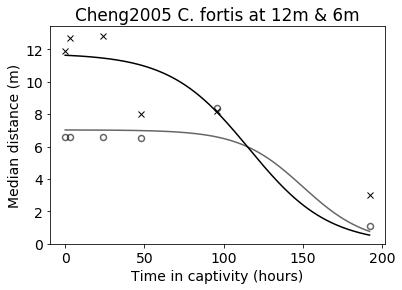

In [71]:
# Plots again the Median homing distance for both papers in one plot

plt.rcParams.update({'font.size': 14}) # Change the font size

# Plot data points
plot(C_HoursInCaptivity, C_Homing_Distance_Median_12m, 'xk', alpha=1.00)
plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'ok', alpha=0.60, fillstyle='none', markeredgewidth=1.5)

# Fit a fitted curves
plot(C_x_prime_12m, C_y_prime_12m, '-k', alpha=1.00)
plot(C_x_prime_6m, C_y_prime_6m, '-k', alpha=0.60)

plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Cheng2005 C. fortis at 12m & 6m')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_12m_6m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_12m_6m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.pdf', bbox_inches='tight', dpi=300)

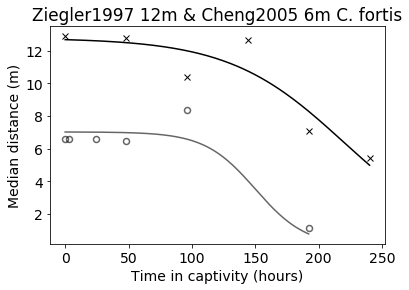

In [72]:
# Plots again the Median homing distance for both papers in one plot

plt.rcParams.update({'font.size': 14}) # Change the font size

# Plot data points
plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'xk', alpha=1.00)
plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'ok', alpha=0.60, fillstyle='none', markeredgewidth=1.5)

# Fit a fitted curves
plot(Z_x_prime_12m, Z_y_prime_12m, '-k', alpha=1.00)
plot(C_x_prime_6m, C_y_prime_6m, '-k', alpha=0.60)

plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.pdf', bbox_inches='tight', dpi=300)

{\displaystyle \psi (t)={\frac {2}{{\sqrt {3\sigma }}\pi ^{1/4}}}\left(1-\left({\frac {t}{\sigma }}\right)^{2}\right)e^{-{\frac {t^{2}}{2\sigma ^{2}}}}}

In [116]:
x = np.linspace(-10, 10, 200)
sigma = 3
y = (2 / (np.sqrt(3*sigma) * np.pi**(1/4))) * (1 - (x / sigma)**2 ) * np.exp(-x**2 / (2 * sigma**2))
t=x
y = (2 / (sqrt(3*3.0) * pow(pi, (1/4)))) * (1 - pow((t / 3.0), 2)) * exp(pow(-t, 2) / (2 * pow(3.0, 2)))
y = (2 / (sqrt(3*sigma) * pow(pi,(1/4)))) * (1 - pow((t / sigma), 2)) * exp(-t**2 / (2 * pow(sigma, 2)))
y = (2 / (sqrt(3*3) * pow(pi,(1/4)))) * (1 - pow((t / 3), 2)) * exp(-t**2 / (2 * pow(3, 2)))


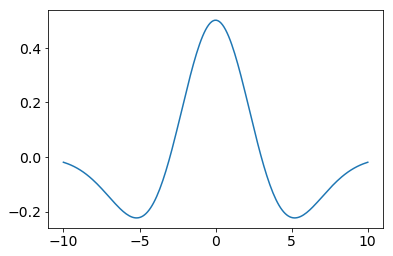

In [117]:
plot(x, y)